In [1]:
%matplotlib inline
%run ../setup/nb_setup

# Science Case Studies: The Age-Velocity Dispersion Relations in APOGEE

Author(s): Keith Hawkins


## Learning goals

The purpose of this tutorial is to: 
1. Introduce the concepts of Age-Velocity Dispersion relations
2. Introduce Cross matching via topcat
3. Introduce/practice velocity calculations via astropy 

Goal: You will derive the Gaia DR2-APOGEE Age-Velocity Dispersion relations. Two additional challenges include: (1) derive the same Age-Velocity Dispersion relations but for  Gaia DR3-APOGEE (hint!: this will require a cross match) and (2) consider uncertainties in age and velocity to build a linear model which converts velocity dispersion into age.

There are **two reach goals** if you can get there:
1. Fit the Age-velocity & Age-velocity dispersion relations simeltenously, using MCMC (emcee) 
2. Use what you learned above to determine whether its better to use the Age-Vz dispersion or Age-V_theta relation to derive the age of a unkonwn population assuming you have well-measured the velocities.

Lets begin!


### Notebook Setup and Package Imports

In [2]:
import numpy as np
import matplotlib.pyplot as p
import astropy
from astropy.table import Table
import scipy.stats
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.coordinates import Galactic
from astropy.coordinates import ICRS
import astropy.coordinates as apycord
import random

We will need to download the APOGEE-ASTRONN dataset that contains age information (along with other information about the APOGEE spectra). This dataset also contains DR2 estimates of velocity but *NOT* DR3 (you will need to do a crossmatch between this file and Gaia EDR3, which we will discuss):

DATA DESCRIPTION : https://www.sdss.org/dr16/data_access/value-added-catalogs/?vac_id=the-astronn-catalog-of-abundances,-distances,-and-ages-for-apogee-dr16-stars

DATA LOCATION : https://data.sdss.org/sas/dr16/apogee/vac/apogee-astronn/apogee_astroNN-DR16-v1.fits

LOCAL MIRROR : https://users.flatironinstitute.org/~apricewhelan/data/surveys/APOGEE_DR16/apogee_astroNN-DR16-v1.fits

Download this dataset
and load it in with astropy!

In [3]:
APOGEE = Table.read("apogee_astroNN-DR16-v1.fits")  # read in the data

In [4]:
# explore the columns:

print(APOGEE.colnames)

['APOGEE_ID', 'LOCATION_ID', 'TELESCOPE', 'RA_APOGEE', 'DEC_APOGEE', 'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'C_H', 'C_H_ERR', 'CI_H', 'CI_H_ERR', 'N_H', 'N_H_ERR', 'O_H', 'O_H_ERR', 'NA_H', 'NA_H_ERR', 'MG_H', 'MG_H_ERR', 'AL_H', 'AL_H_ERR', 'SI_H', 'SI_H_ERR', 'P_H', 'P_H_ERR', 'S_H', 'S_H_ERR', 'K_H', 'K_H_ERR', 'CA_H', 'CA_H_ERR', 'TI_H', 'TI_H_ERR', 'TIII_H', 'TIII_H_ERR', 'V_H', 'V_H_ERR', 'CR_H', 'CR_H_ERR', 'MN_H', 'MN_H_ERR', 'FE_H', 'FE_H_ERR', 'CO_H', 'CO_H_ERR', 'NI_H', 'NI_H_ERR', 'dist', 'dist_error', 'dist_model_error', 'nn_parallax', 'nn_parallax_error', 'nn_parallax_model_error', 'fakemag', 'fakemag_error', 'weighted_dist', 'weighted_dist_error', 'RA', 'DEC', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'phot_g_mean_mag', 'bp_rp', 'VHELIO_AVG', 'age', 'age_linear_correct', 'age_lowess_correct', 'age_total_error', 'age_model_error', 'source_id', 'galr', 'galphi', 'galz', 'galvr', 'galvt', 'galvz', 'galr_err', 'galphi_err', 'galz_err', 'galvr_err', 'galvt_err', 'galvz_e

The goal here is to determine how velocity (and velocity dispersion) is correlated with age. 

As such we will need to find the (precomputed DR2) velocity columns; and age columns (based on the cell above). 

Not all velociities and ages are measured with the same precision so we will also want to apply some very simple quality control cuts. So lets do that in the next cell

In [5]:
# lets create a quality
v_err_lim = 5  # define the limiting velocity uncertinaty in all axes
age_err_lim = 0.3  # age uncertainty limit in percent
dist_err_lim = 0.15  # distance error in percent

ok = np.where(
    (APOGEE["galvr_err"] < v_err_lim)
    & (APOGEE["galvt_err"] < v_err_lim)
    & (APOGEE["galvz_err"] < v_err_lim)
    & (APOGEE["age_total_error"] / APOGEE["age"] < age_err_lim)
    & (APOGEE["dist_error"] / APOGEE["dist"] < dist_err_lim)
    & (APOGEE["age"] > 0)
)[0]

print("There are %i stars that pass the quality controls" % len(ok))
D = APOGEE[ok]  # lets now subselect the 'GOOD' data

There are 59381 stars that pass the quality controls


With the 'quality' sample in hand, lets now try to figure out how velocity and velocity dispersion depends on age in this sample. We will start by simply plotting velocity in all directions as a function of age

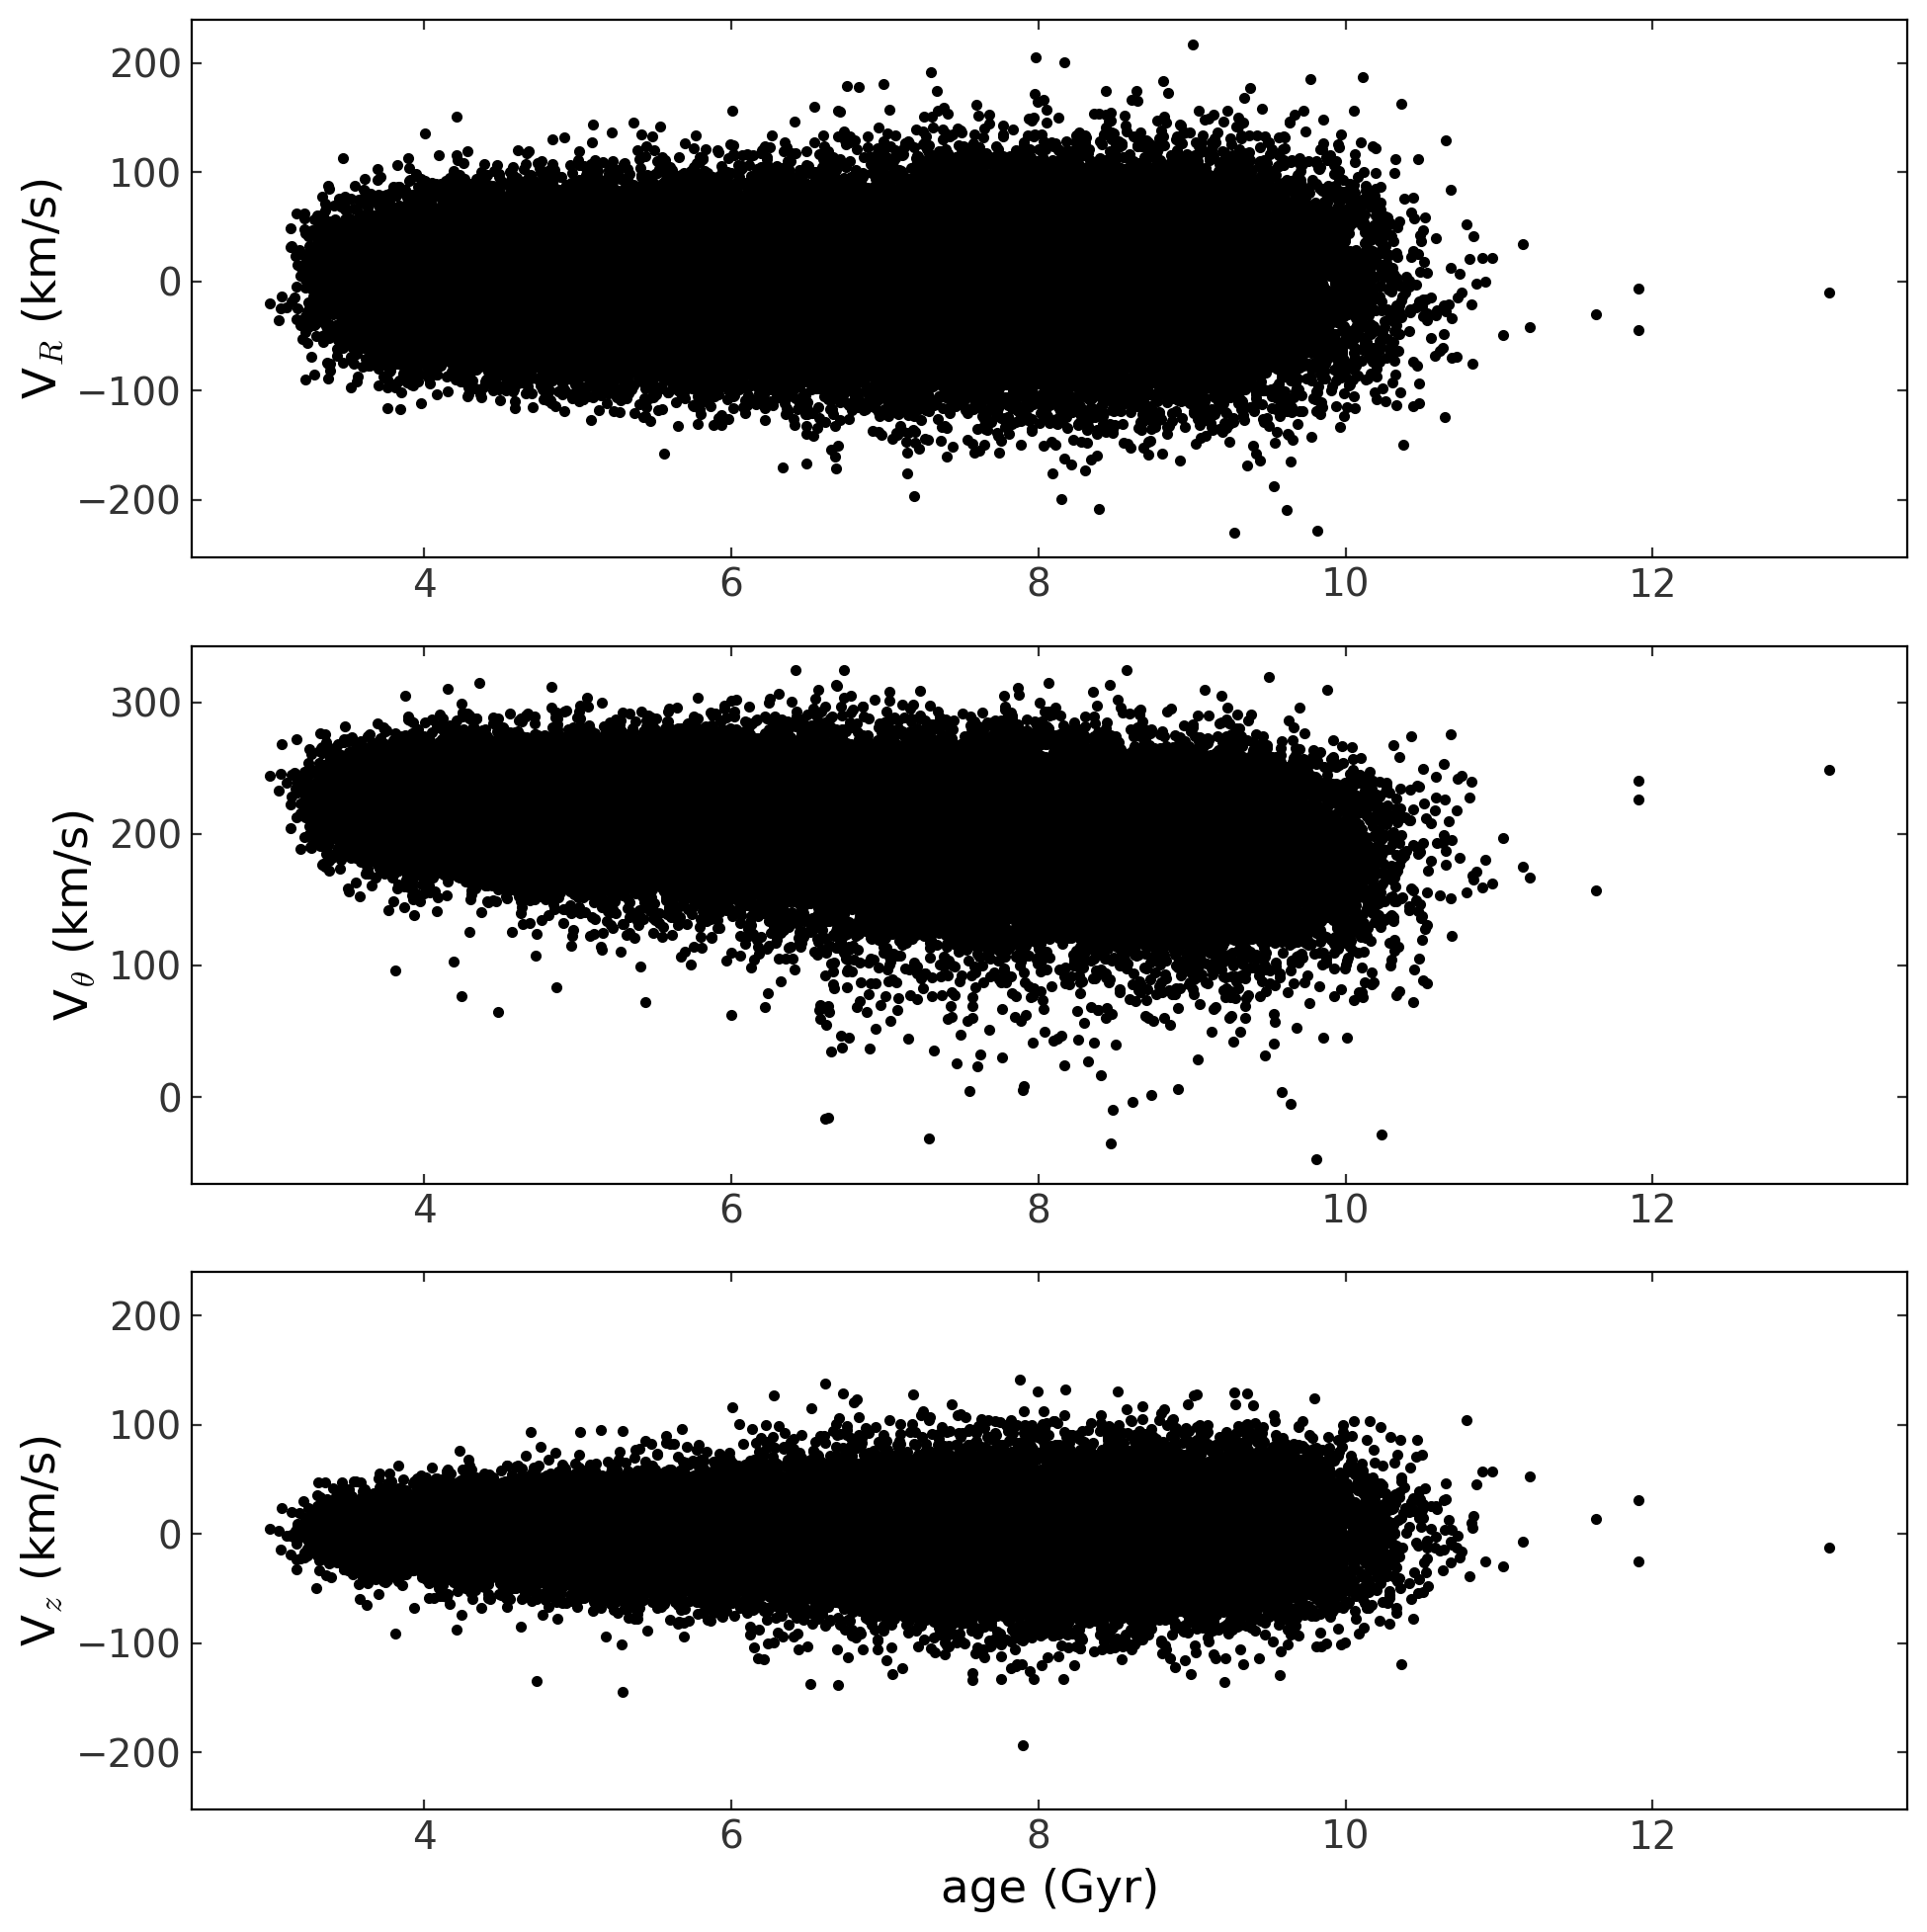

In [6]:
# Now we want to plot how the velocities depends on age
p.figure(figsize=(10, 10))
ax1 = p.subplot(3, 1, 1)
p.plot(D["age"], D["galvr"], "k.")
p.ylabel("V$_R$ (km/s)")

ax2 = p.subplot(3, 1, 2, sharex=ax1)
p.plot(D["age"], D["galvt"], "k.")
p.ylabel(r"V$_{\theta}$ (km/s)")

ax3 = p.subplot(3, 1, 3, sharey=ax1)
p.plot(D["age"], D["galvz"], "k.")
p.ylabel("V$_z$ (km/s)")
p.xlabel("age (Gyr)")
p.tight_layout()

From the above plots we can see that:
1. Mostly velocities are indepdent of age (no signficant relationships), except maybe in V_theta
2. The velocity dispersion in all velcoity directons likley grows with increasing age

So now lets bin by age and see if we can determine the relationship between age and velocity.

In [7]:
# for each star we will place them into bins by age using scipy.stats.binned_statistic

age_bins = [3, 4, 5, 6, 7, 8, 9, 10]  # define the limits of each bin

## With the ages now binned up lets plot compute the bin's mean age and dispersion in age for each velocity direction
mean_VR, bin_edge, inds = scipy.stats.binned_statistic(
    D["age"], D["galvr"], statistic="mean", bins=age_bins
)
std_VR, bin_edge, inds = scipy.stats.binned_statistic(
    D["age"], D["galvr"], statistic="std", bins=age_bins
)

mean_Vz, bin_edge, inds = scipy.stats.binned_statistic(
    D["age"], D["galvz"], statistic="mean", bins=age_bins
)
std_Vz, bin_edge, inds = scipy.stats.binned_statistic(
    D["age"], D["galvz"], statistic="std", bins=age_bins
)

mean_Vt, bin_edge, inds = scipy.stats.binned_statistic(
    D["age"], D["galvt"], statistic="mean", bins=age_bins
)
std_Vt, bin_edge, inds = scipy.stats.binned_statistic(
    D["age"], D["galvt"], statistic="std", bins=age_bins
)

bincen = [
    (bin_edge[i + 1] + bin_edge[i]) / 2.0 for i in range(len(age_bins) - 1)
]  # this set the bin centers

Now that we have binned the data and determined the mean and dispersion in each velocity direction, as a sanity check (which are incredibly important to do), lets overplot the data and the binned results to ensure it looks ok.

# The Age-Velocity Dispersion Relations in APOGEE-Gaia DR2


Now we are ready to plot the age velocity disperison relations for each component for APOGEE-Gaia DR2. 

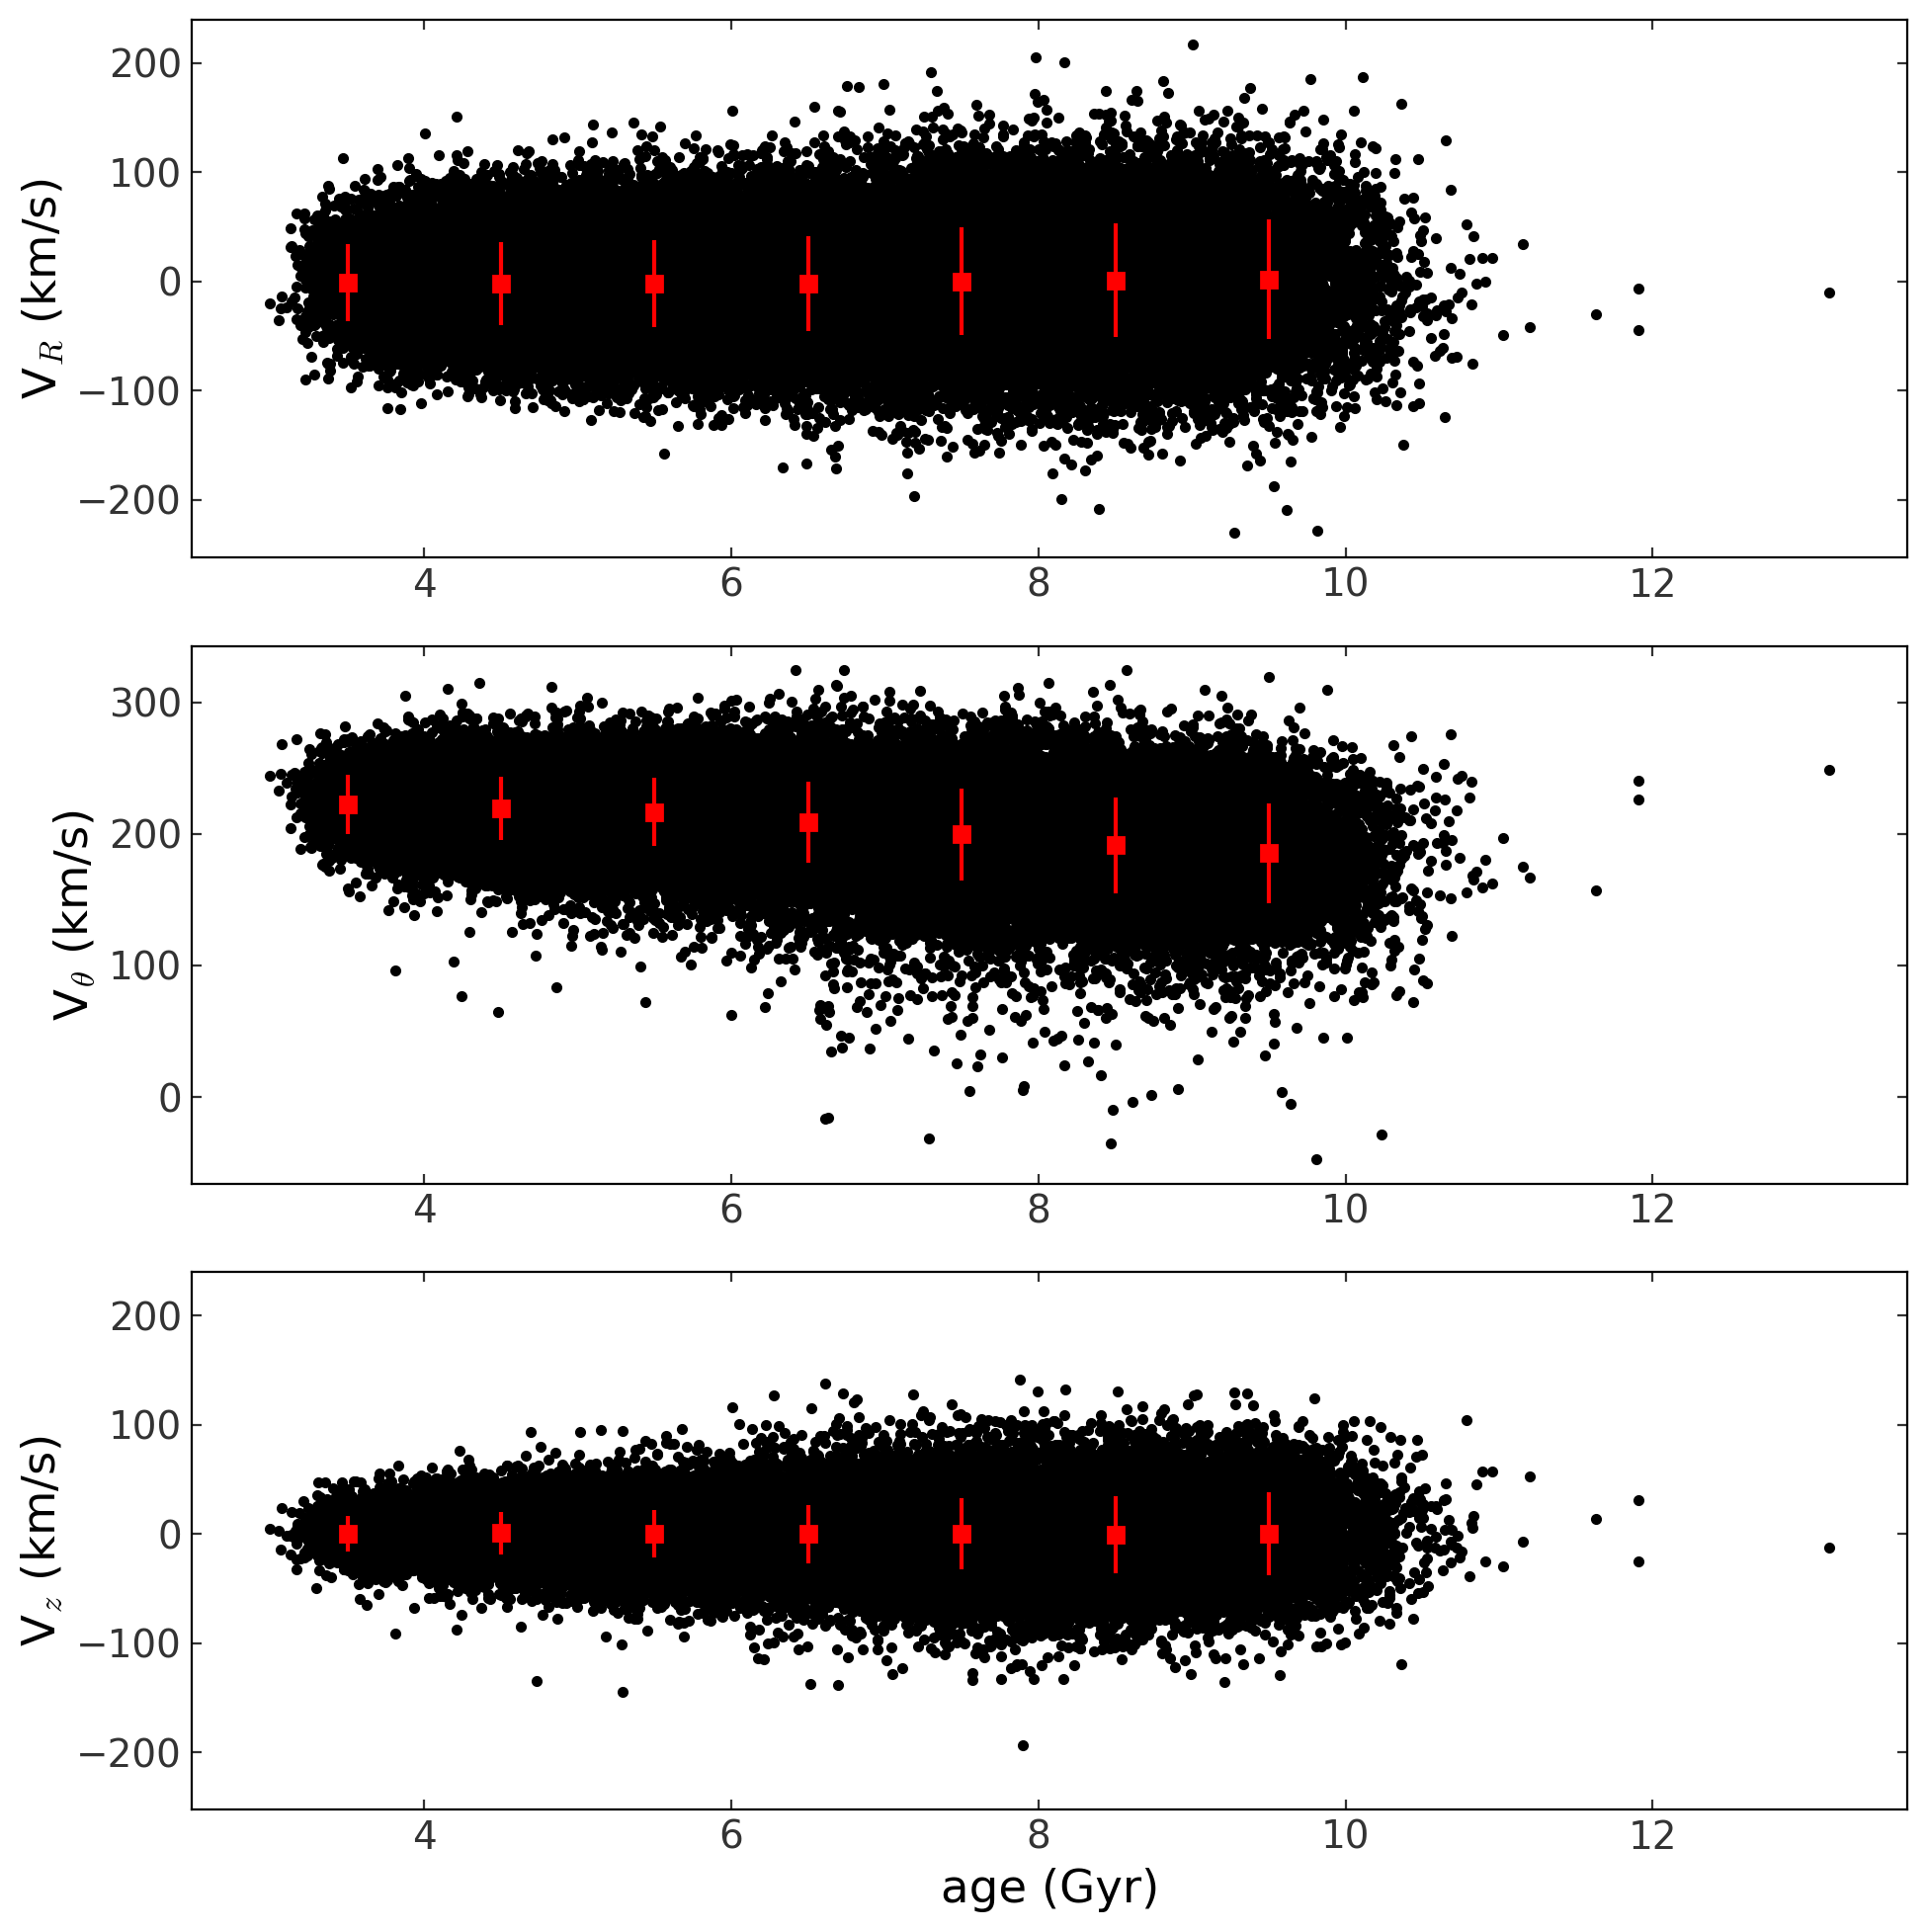

In [8]:
p.figure(figsize=(10, 10))
ax1 = p.subplot(3, 1, 1)
p.plot(D["age"], D["galvr"], "k.")
p.errorbar(bincen, mean_VR, yerr=std_VR, fmt="s", color="r", zorder=3)
p.ylabel("V$_R$ (km/s)")

ax2 = p.subplot(3, 1, 2, sharex=ax1)
p.plot(D["age"], D["galvt"], "k.")
p.errorbar(bincen, mean_Vt, yerr=std_Vt, fmt="s", color="r", zorder=3)
p.ylabel(r"V$_{\theta}$ (km/s)")

ax3 = p.subplot(3, 1, 3, sharey=ax1)
p.plot(D["age"], D["galvz"], "k.")
p.errorbar(bincen, mean_Vz, yerr=std_Vz, fmt="s", color="r", zorder=3)
p.ylabel("V$_z$ (km/s)")
p.xlabel("age (Gyr)")
p.tight_layout()

With the data binned we can now explore the velocity disperison as a function of age

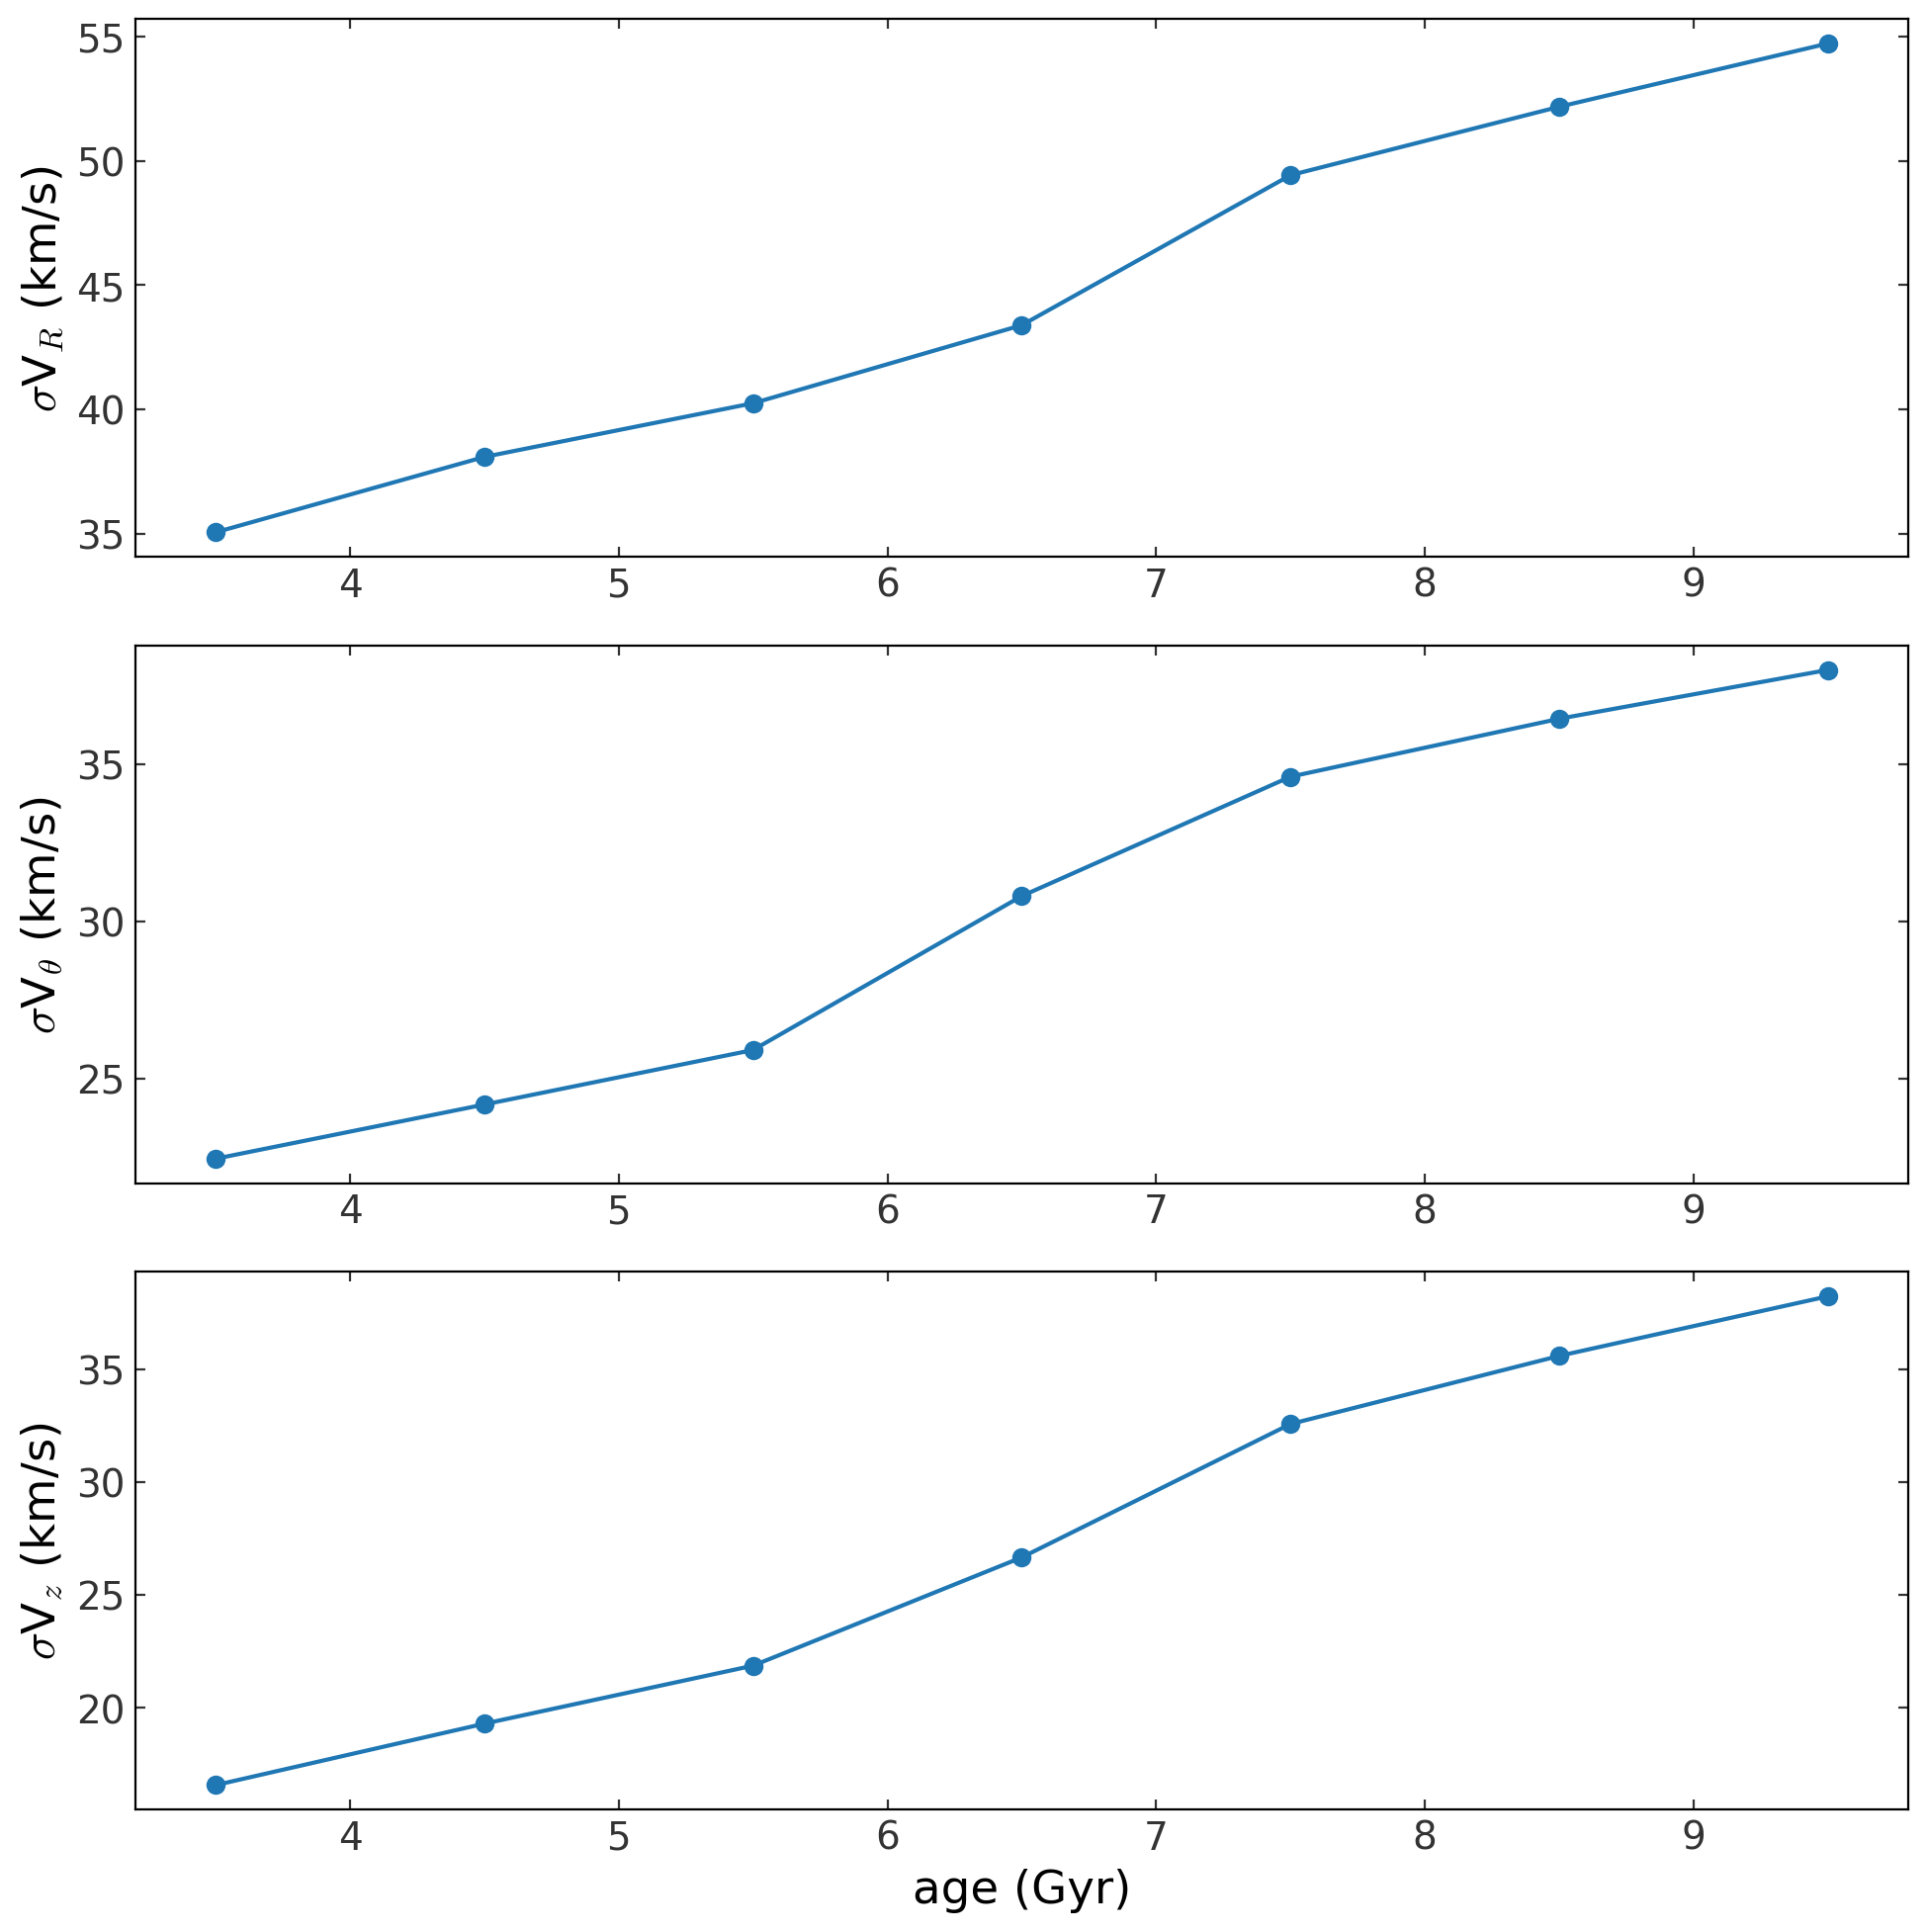

In [9]:
p.figure(figsize=(10, 10))
ax1 = p.subplot(3, 1, 1)
p.plot(bincen, std_VR, "-o")
p.ylabel(r"$\sigma$V$_R$ (km/s)")

ax2 = p.subplot(3, 1, 2, sharex=ax1)
p.plot(bincen, std_Vt, "-o")
p.ylabel(r"$\sigma$V$_{\theta}$ (km/s)")

ax1 = p.subplot(3, 1, 3, sharex=ax1)
p.plot(bincen, std_Vz, "-o")
p.ylabel(r"$\sigma$V$_z$ (km/s)")
p.xlabel("age (Gyr)")
p.tight_layout()

*We now see that the age-velocity dispersion relations are roughly linear such that VELOCITY DISPERSION INCREASES with INCREASING age as expected.*

# The Age-Velocity Dispersion Relations in APOGEE-Gaia EDR3!

Let us now redo the above but with EDR3 data instead! This will require us to compute the velocities (and their uncertainties -- challenge) from the EDR3 data directly.

You will need to first cross-match (via ADQL/TOPCAT/TAP QUERY/ASTROQUERY) orginal table with ED3. We will explore how to use topcat in this workshop but its trivial to do this via an ADQL/TAP Query.

Once the cross match is done, lets read it in.

In [10]:
# in this case a cross match was done with topcat so lets load in that.

APOGEEDR3 = Table.read(
    "apogee_astroNN-DR16-v1_DR3.fits"
)  # replace with your data table
ok = np.where(
    (APOGEEDR3["parallax_error"] / APOGEEDR3["parallax"] < 0.3)
    & (APOGEEDR3["parallax"] > 0)
)
APOGEEDR3 = APOGEEDR3[ok]
APOGEEDR3["dist_dr3"] = (
    1.0 / APOGEEDR3["parallax"]
)  # for easy lets just assume that the distance is 1/parallax

# lets explore the columns as well; take note of the parallax proper motion etc.
print(APOGEEDR3.colnames)

['APOGEE_ID', 'LOCATION_ID', 'TELESCOPE', 'RA_APOGEE', 'DEC_APOGEE', 'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'C_H', 'C_H_ERR', 'CI_H', 'CI_H_ERR', 'N_H', 'N_H_ERR', 'O_H', 'O_H_ERR', 'NA_H', 'NA_H_ERR', 'MG_H', 'MG_H_ERR', 'AL_H', 'AL_H_ERR', 'SI_H', 'SI_H_ERR', 'P_H', 'P_H_ERR', 'S_H', 'S_H_ERR', 'K_H', 'K_H_ERR', 'CA_H', 'CA_H_ERR', 'TI_H', 'TI_H_ERR', 'TIII_H', 'TIII_H_ERR', 'V_H', 'V_H_ERR', 'CR_H', 'CR_H_ERR', 'MN_H', 'MN_H_ERR', 'FE_H', 'FE_H_ERR', 'CO_H', 'CO_H_ERR', 'NI_H', 'NI_H_ERR', 'dist', 'dist_error', 'dist_model_error', 'nn_parallax', 'nn_parallax_error', 'nn_parallax_model_error', 'fakemag', 'fakemag_error', 'weighted_dist', 'weighted_dist_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'phot_g_mean_mag', 'bp_rp', 'VHELIO_AVG', 'age', 'age_linear_correct', 'age_lowess_correct', 'age_total_error', 'age_model_error', 'source_id', 'galr', 'galphi', 'galz', 'galvr', 'galvt', 'galvz', 'galr_err', 'galphi_err', 'galz_err', 'galvr_err', 'galvt_err', 'galvz_err', 'galvr_g

With the data set now loaded lets start by making a definition that will compute velocities with astropy.

In [11]:
# --- ok lets now compute some velocities with EDR3 data! We start by making a defintion to do this.
def compute_vels(ra, dec, pmra, pmdec, rv, dist, V0=[11.1, 245.0, 7.25], R0=8.3):
    # define an ICRS coord for each star
    icrs = ICRS(
        ra=ra * u.deg,
        dec=dec * u.deg,
        distance=dist * u.kpc,
        pm_ra_cosdec=pmra * u.mas / u.yr,
        pm_dec=pmdec * u.mas / u.yr,
        radial_velocity=rv * u.km / u.s,
    )

    # Define the Galactic non-rotating rest frame: (V0 = solar velocity in Galactic rest fram; R0 = solar radius)
    v_sun = apycord.CartesianDifferential(V0 * u.km / u.s)
    gc_frame = apycord.Galactocentric(
        galcen_distance=R0 * u.kpc, z_sun=25.0 * u.pc, galcen_v_sun=v_sun
    )
    # convert to GC frame
    cg = icrs.transform_to(gc_frame)
    # cg.representation= 'cartesian'
    cg.representation = "cylindrical"  # and now to clylindrical coords
    VR = cg.d_rho.to(u.km / u.s).value
    VT = (
        (cg.d_phi * cg.rho).to(u.km / u.s, equivalencies=u.dimensionless_angles()).value
    )
    VZ = cg.d_z.to(u.km / u.s).value

    return VR, -VT, VZ

With the definition, we can now convert the observables into velocities by calling the defintion from above. We can also do this iterativley where in each iteration we perturb the input observables by the uncertainties. This will enable us to estimate the velocity uncertainties via monte carlo realizations. NOTE: This assumes that the uncertainties in the observables are INDEPENDENT! Really one should actually sample from the covariance matrix (provided by Gaia)

In [12]:
# ----lets now deal with the velocity uncertinaties via monte carlo realizations

allVR = []
allVT = []
allVZ = []
niter = 10 #lets iterate this number of times while randomly perturbing the inputs
for i in range(niter):
    pmra_perturb = np.random.normal(0, APOGEEDR3["pmra_error"])
    pmdec_perturb = np.random.normal(0, APOGEEDR3["pmdec_error"])
    rv_perturb = np.random.normal(
        0, [0.5] * len(APOGEEDR3)
    )  # RV ERROR Column was missing so assume 0.50 km/s, as this is just a tutorial
    parallax_perturb = np.random.normal(0, APOGEEDR3["parallax_error"])

    parallaxes = np.array(APOGEEDR3["parallax"]) + parallax_perturb
    parallaxes[
        parallaxes < 0
    ] = 0.01  # replace all negative parallaxes to 0.01 mas (again just for tutorial; you can actually infer alot from neg. parallax)

    # We assume here that (1) errors are indepdent; (2) negliable errors on RA/DEC;
    A = compute_vels(
        np.array(APOGEEDR3["ra_dr3"]),
        np.array(APOGEEDR3["dec_dr3"]),
        np.array(APOGEEDR3["pmra_dr3"] + pmra_perturb),
        np.array(APOGEEDR3["pmdec_dr3"] + pmdec_perturb),
        np.array(APOGEEDR3["VHELIO_AVG"] + rv_perturb),
        1.0 / (parallaxes),
    )
    allVR.append(A[0])
    allVT.append(A[1])
    allVZ.append(A[2])

APOGEEDR3["galvr_dr3"] = np.median(allVR, axis=0)
APOGEEDR3["galvr_err_dr3"] = np.std(allVR, axis=0)
APOGEEDR3["galvt_dr3"] = np.median(allVT, axis=0)
APOGEEDR3["galvt_err_dr3"] = np.std(allVT, axis=0)
APOGEEDR3["galvz_dr3"] = np.median(allVZ, axis=0)
APOGEEDR3["galvz_err_dr3"] = np.std(allVZ, axis=0)

Now that we have the velocities and their uncertainties with EDR3 data, lets make the same quality control cuts as before.

In [13]:
ok = np.where(
    (APOGEEDR3["galvr_err_dr3"] < v_err_lim)
    & (APOGEEDR3["galvt_err_dr3"] < v_err_lim)
    & (APOGEEDR3["galvz_err_dr3"] < v_err_lim)
    & (APOGEEDR3["age_total_error"] / APOGEEDR3["age"] < age_err_lim)
    & (APOGEEDR3["dist_error"] / APOGEEDR3["dist"] < dist_err_lim)
    & (APOGEEDR3["age"] > 0)
)[0]

print("There are %i stars that pass the quality controls" % len(ok))
D_DR3 = APOGEEDR3[ok]

There are 51045 stars that pass the quality controls


We can now plot the EDR3 version of the age velocity relations.

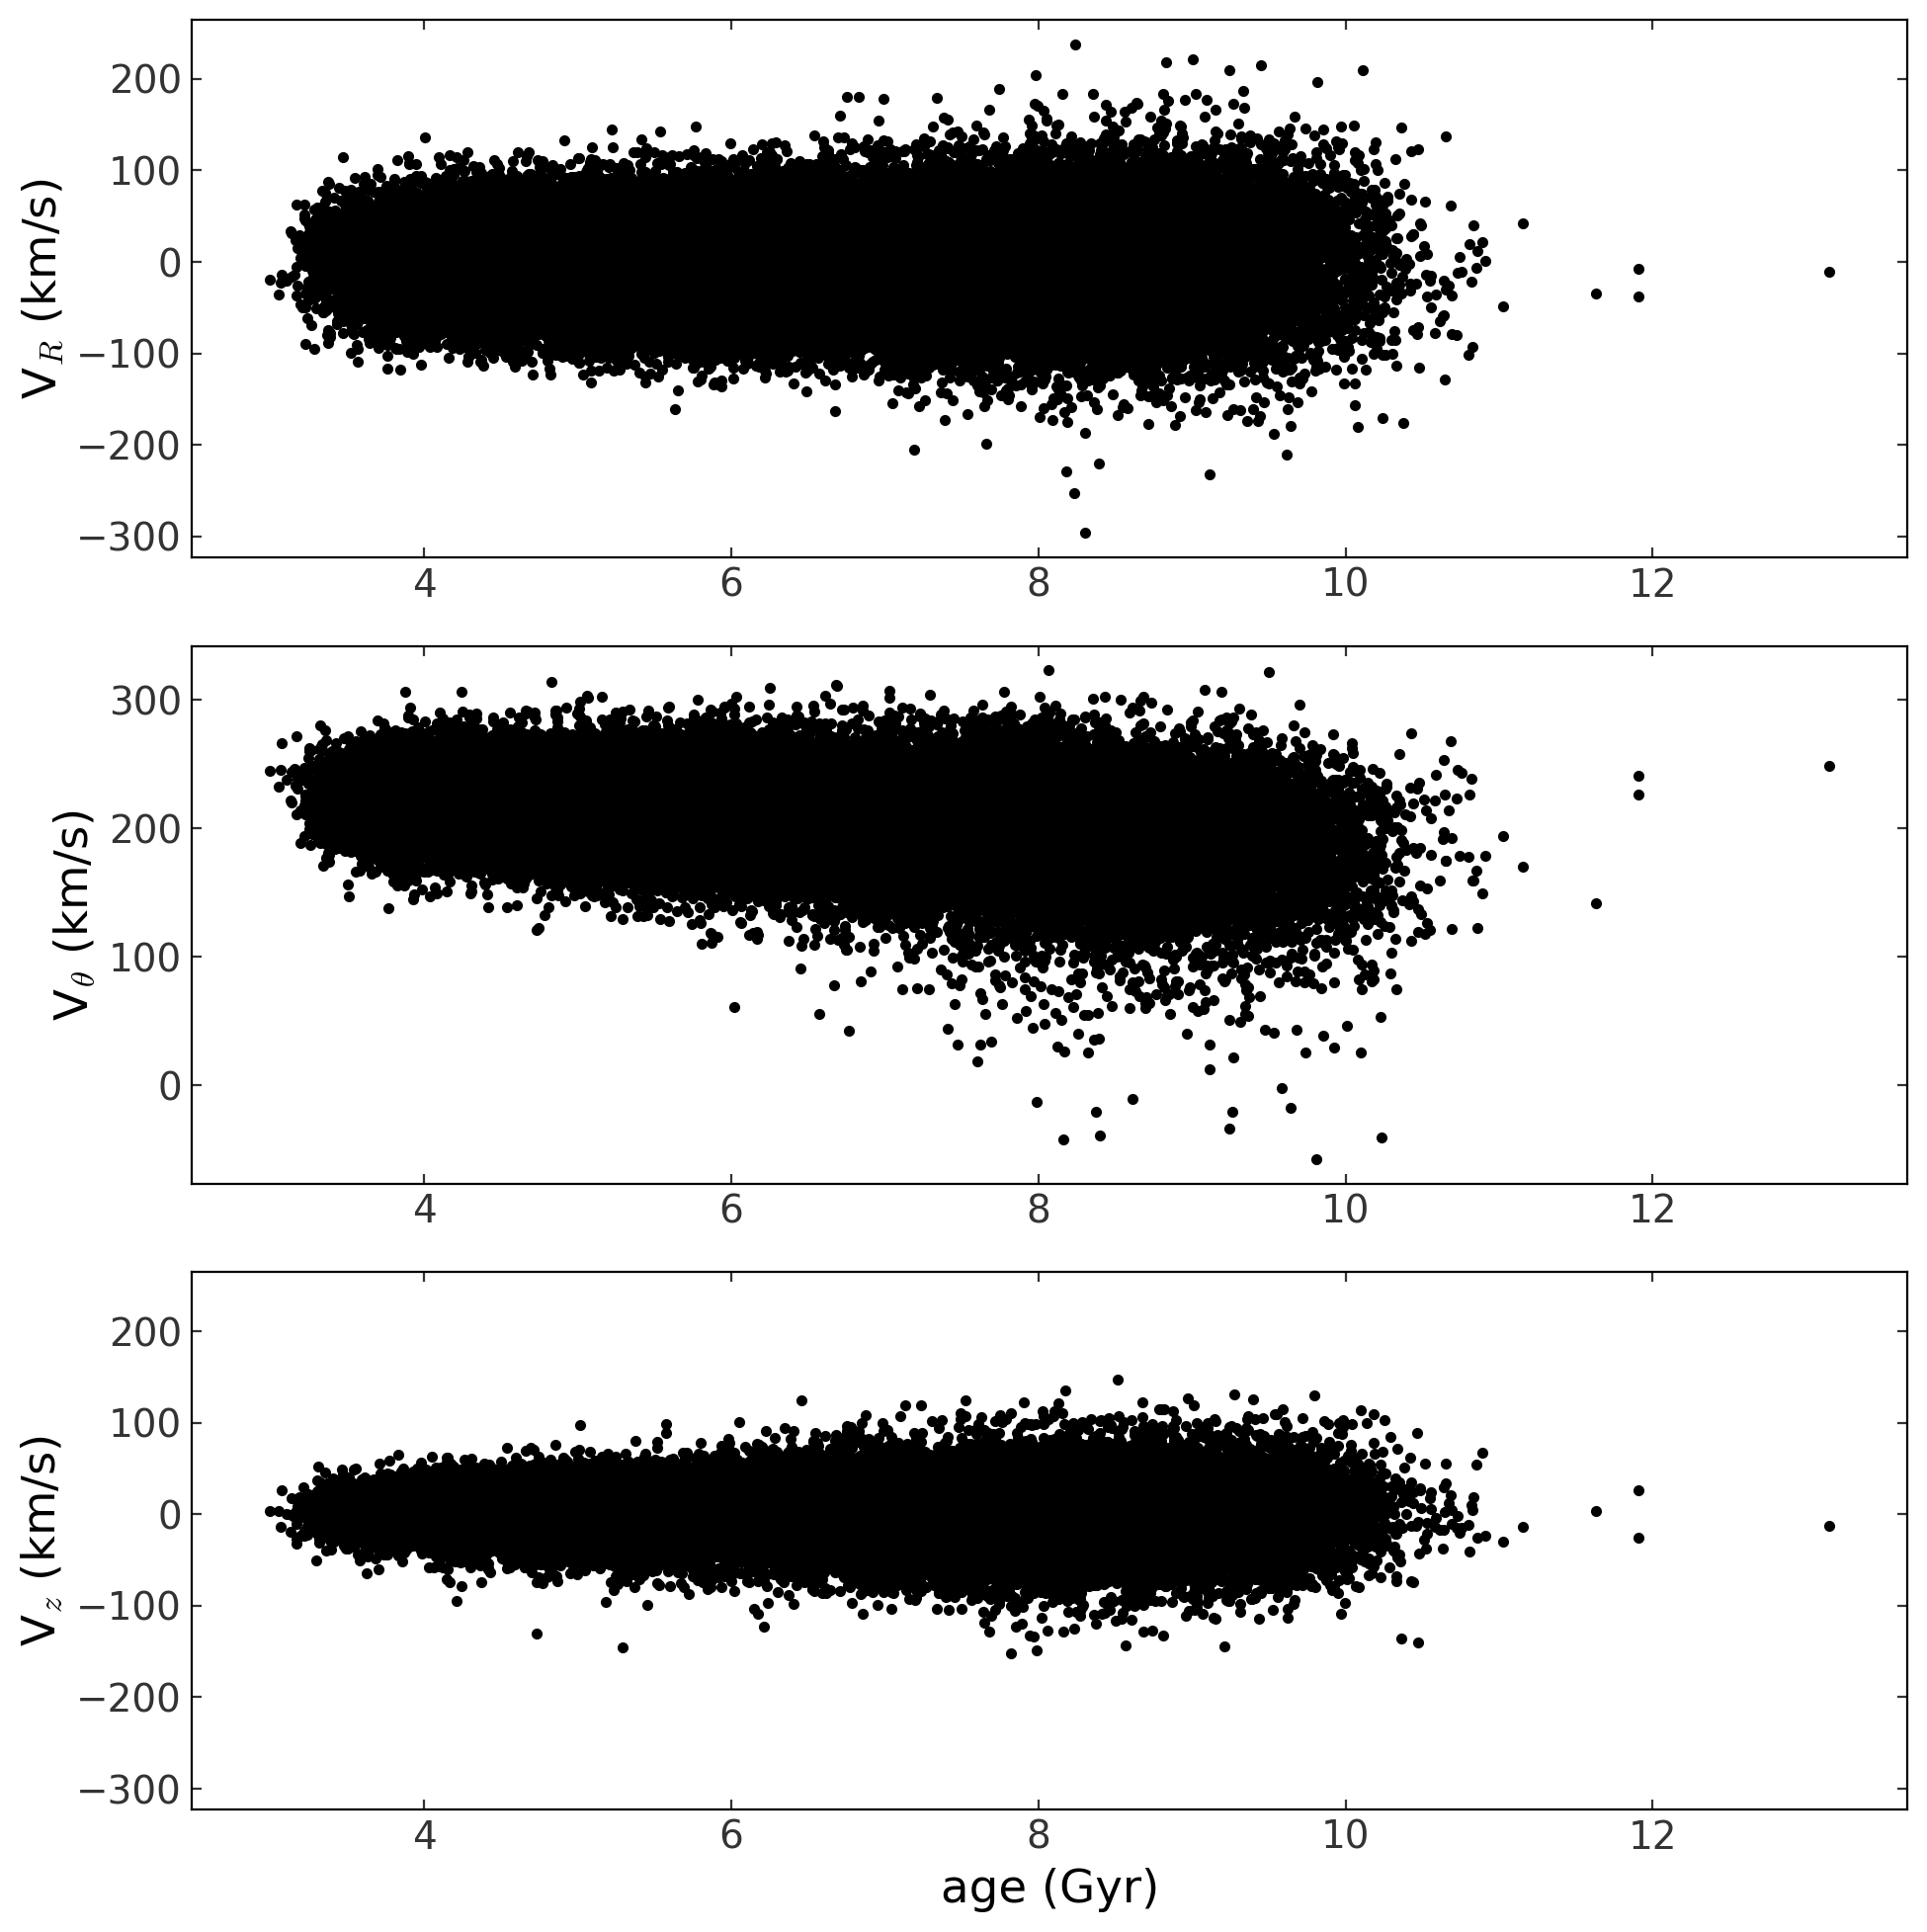

In [14]:
p.figure(figsize=(10, 10))
ax1 = p.subplot(3, 1, 1)
p.plot(D_DR3["age"], D_DR3["galvr_dr3"], "k.")
# p.errorbar(bincen,mean_VR,yerr=std_VR, fmt='s',color='r',zorder=3 )
p.ylabel("V$_R$ (km/s)")

ax2 = p.subplot(3, 1, 2, sharex=ax1)
p.plot(D_DR3["age"], D_DR3["galvt_dr3"], "k.")
# p.errorbar(bincen,mean_Vt,yerr=std_Vt, fmt='s',color='r',zorder=3 )
p.ylabel(r"V$_{\theta}$ (km/s)")

ax3 = p.subplot(3, 1, 3, sharey=ax1)
p.plot(D_DR3["age"], D_DR3["galvz_dr3"], "k.")
# p.errorbar(bincen,mean_Vz,yerr=std_Vz, fmt='s',color='r',zorder=3 )
p.ylabel("V$_z$ (km/s)")
p.xlabel("age (Gyr)")
p.tight_layout()

We must now bin the data in the same way (by age) as for the DR3 results and compute the mean and std of the velocity in each age bin.

In [15]:
mean_VR_dr3, bin_edge, inds = scipy.stats.binned_statistic(
    D_DR3["age"], D_DR3["galvr_dr3"], statistic="mean", bins=age_bins
)
std_VR_dr3, bin_edge, inds = scipy.stats.binned_statistic(
    D_DR3["age"], D_DR3["galvr_dr3"], statistic="std", bins=age_bins
)

mean_Vz_dr3, bin_edge, inds = scipy.stats.binned_statistic(
    D_DR3["age"], D_DR3["galvz_dr3"], statistic="mean", bins=age_bins
)
std_Vz_dr3, bin_edge, inds = scipy.stats.binned_statistic(
    D_DR3["age"], D_DR3["galvz_dr3"], statistic="std", bins=age_bins
)

mean_Vt_dr3, bin_edge, inds = scipy.stats.binned_statistic(
    D_DR3["age"], D_DR3["galvt_dr3"], statistic="mean", bins=age_bins
)
std_Vt_dr3, bin_edge, inds = scipy.stats.binned_statistic(
    D_DR3["age"], D_DR3["galvt_dr3"], statistic="std", bins=age_bins
)

bincen = [
    (bin_edge[i + 1] + bin_edge[i]) / 2.0 for i in range(len(age_bins) - 1)
]  # this set the bin centers

Finally, we plot the age velocity dispersion relations for APOGEE-DR2 and APOGEE-EDR3 datasets. 

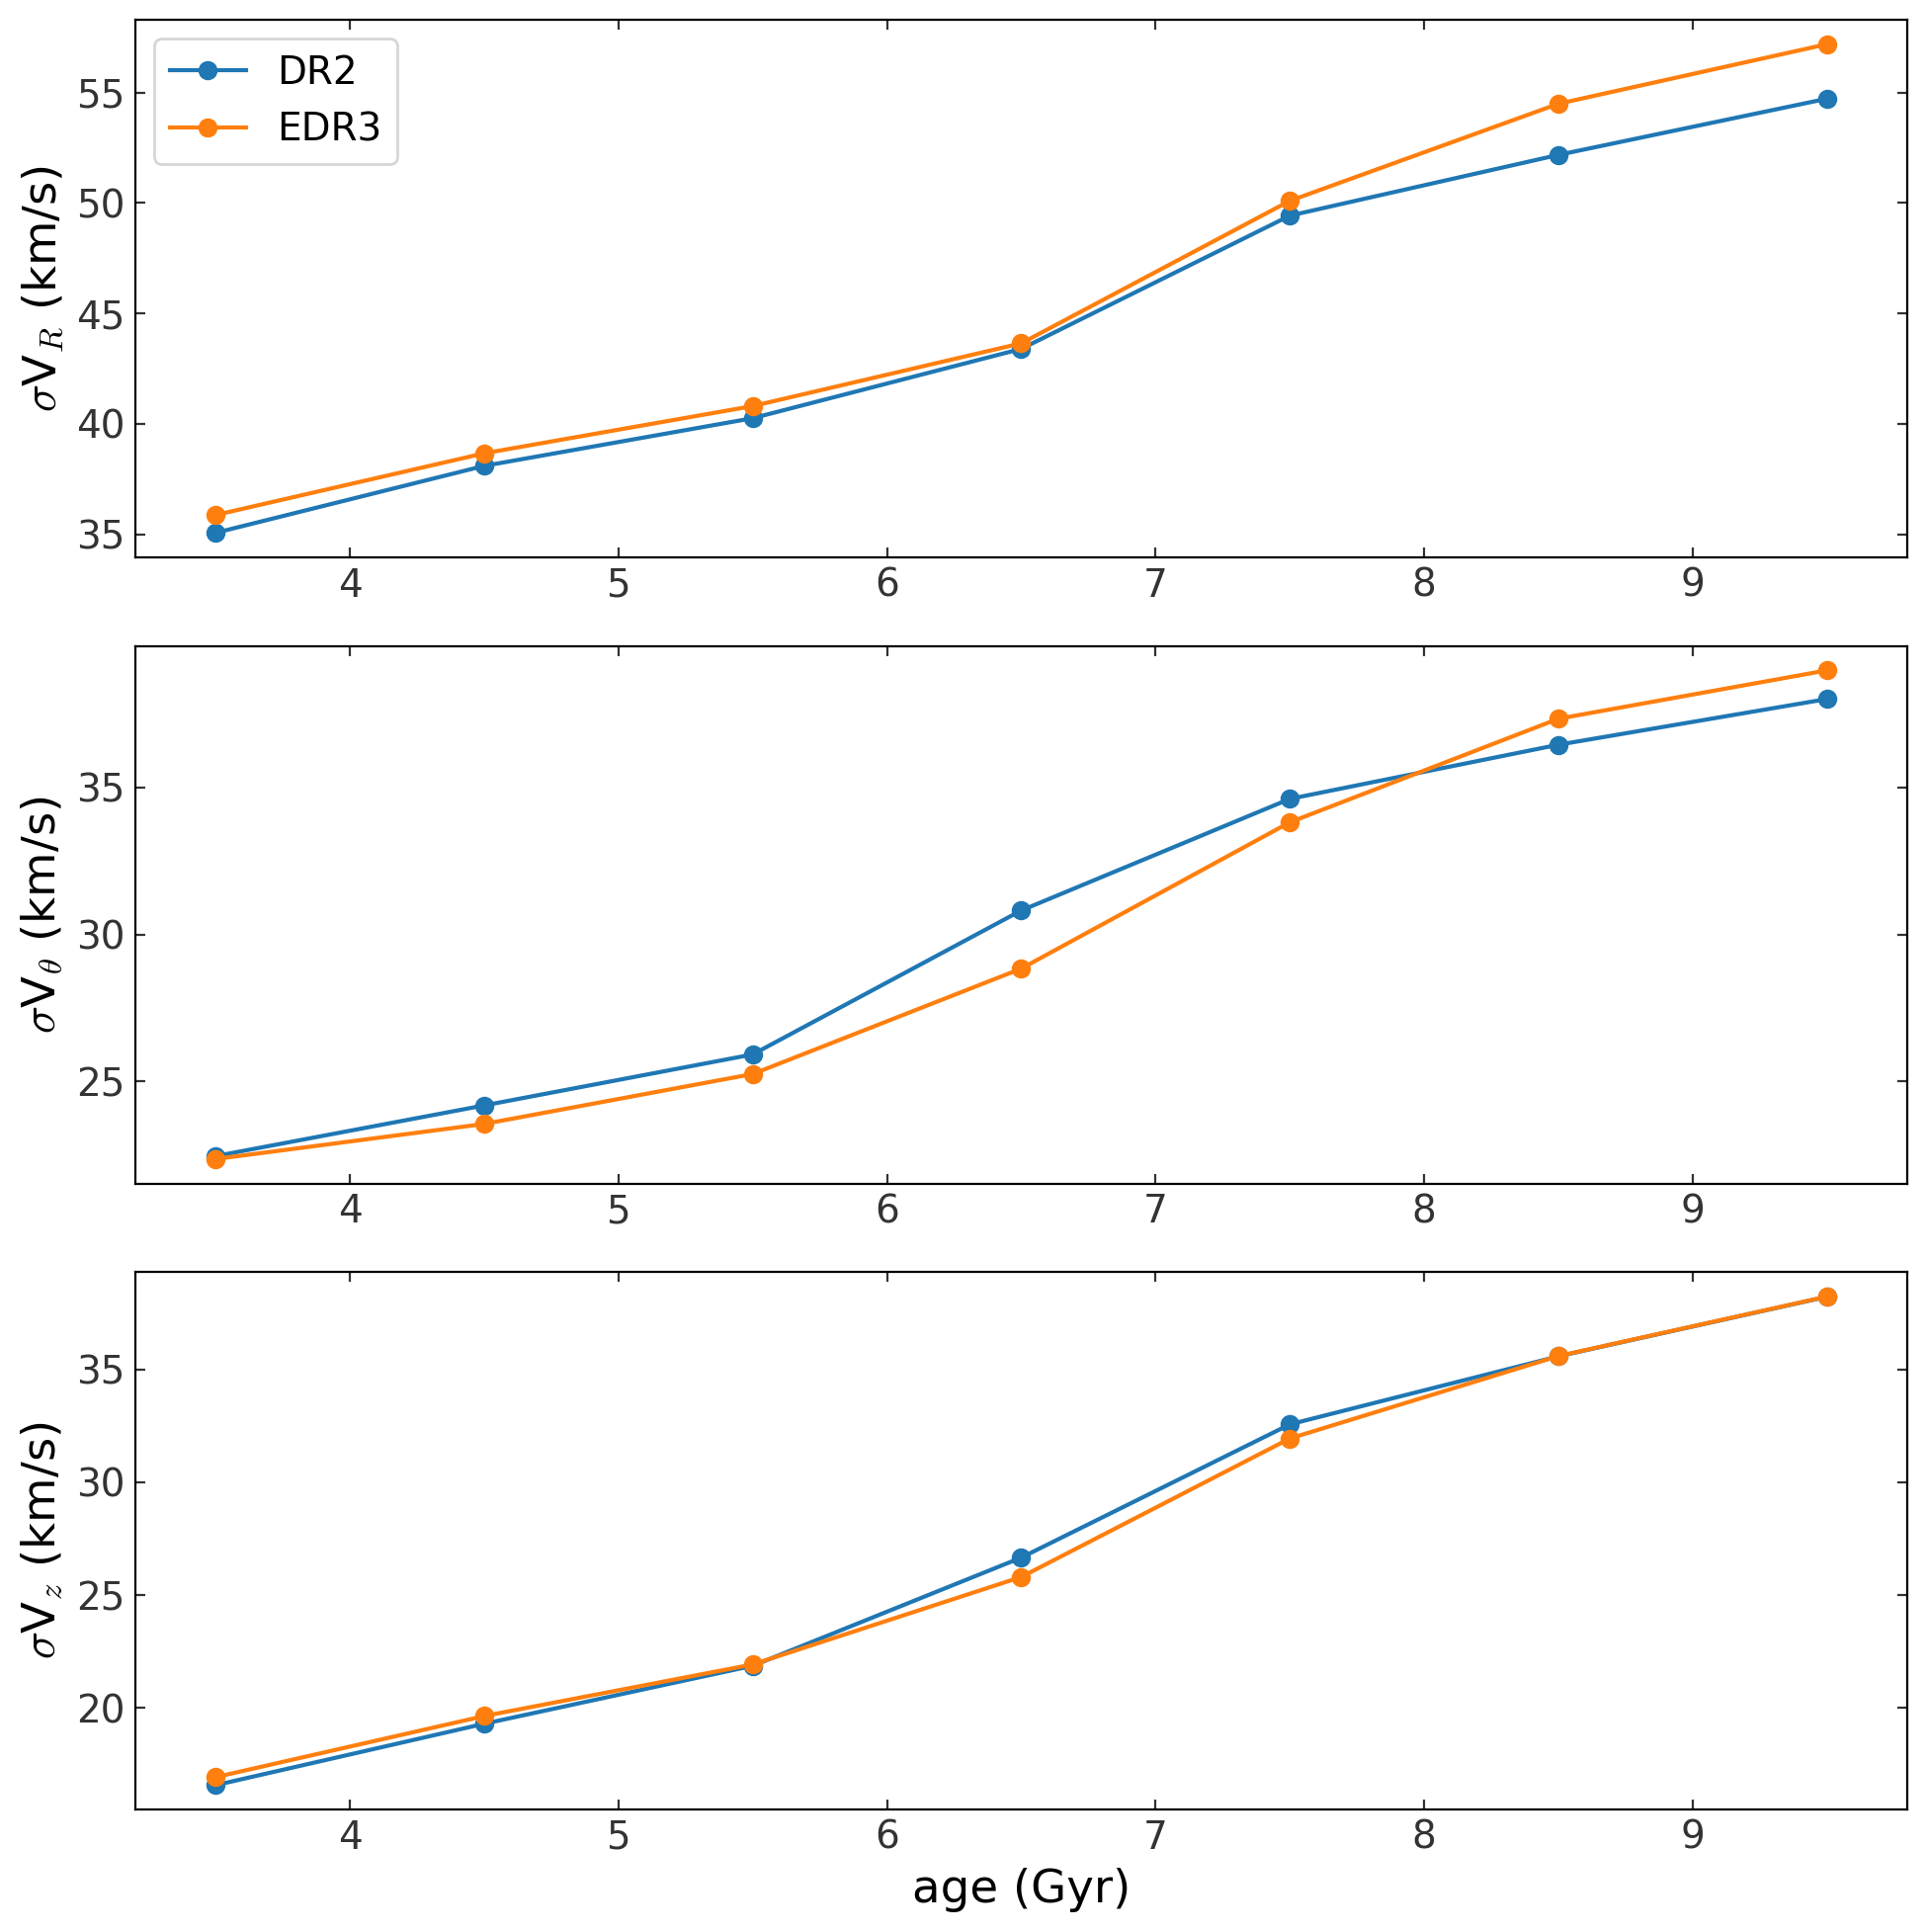

In [16]:
p.figure(figsize=(10, 10))
ax1 = p.subplot(3, 1, 1)
p.plot(bincen, std_VR, "-o", label="DR2")
p.plot(bincen, std_VR_dr3, "-o", label="EDR3")
p.legend()
p.ylabel(r"$\sigma$V$_R$ (km/s)")

ax2 = p.subplot(3, 1, 2, sharex=ax1)
p.plot(bincen, std_Vt, "-o", label="DR2")
p.plot(bincen, std_Vt_dr3, "-o", label="EDR3")
p.ylabel(r"$\sigma$V$_{\theta}$ (km/s)")

ax1 = p.subplot(3, 1, 3, sharex=ax1)
p.plot(bincen, std_Vz, "-o")
p.plot(bincen, std_Vz_dr3, "-o", label="EDR3")
p.ylabel(r"$\sigma$V$_z$ (km/s)")
p.xlabel("age (Gyr)")
p.tight_layout()

*We now see that the age-velocity dispersion relations are roughly linear such that VELOCITY DISPERSION INCREASES with INCREASING age as expected. If there are some differences between DR2 and EDR3, why might they exist.*

# Reach Challenge I: Fitting the Age-Velocity & Age-Velocity Dispersion Relations Simultaneously with Linear Model and MCMC 

Challenge: If you finish, try to figure out a way to define the age velocity realtion *without* binning the data. (Hint: This can be done via writing down a linear model for how velocity and velocity dispersion depends on age and then comparing that model in the data space using emcee!)

In [17]:
# so lets begin this by importing the required packages to fit the age velocity relation 
import emcee
import corner
import scipy
import scipy.stats

So we need to write down a model 

So we will model the velocity distribution as a function of age such that

$$V_i = m_{V_i-age} * age + b_{V_i-age}$$

where i represents the velocity component (i.e., i = {r, T, z} ), $m_{V_i-age}$ (called m in code) represents the slope of the age-velocity relation, and $b_{V_i-age}$ (called b2 in the code) represents the intercept of the age-velocity relation

Additionally, we will mdoel the velocity dispersion distribtion as a function of age such that:

$$\sigma V_i = m_{\sigma V_i-age} * age + b_{\sigma V_i-age}$$

Here, $m_{\sigma V_i-age}$ (called m in the code) represents the slope of the age-velocity disperison relation, and $b_{\sigma V_i-age}$ (called b in the code) represents the intercept of the age-velocity dispersion relation

Now that we have written down a linear model, which describes how both velocity and velocity disperison depends on age, we will need to fit the model to the data. Remember that the data we have is the measured velocities ($V_i$).

We will do this in a Bayesian way.

So lets quickly recap. 

Bayes theorm states that the probability of our model given the data that we have observed (i.e., $p(\theta∣data)$, the postieror) is proportional to the probility of measuring the data that we do given the model ($p(data∣\theta)$ often called the liklihood function) multiplied by the prior information we have that our model parameters are correct ($p(\theta)$, the prior). This is mathematically,

$$p(\theta∣data) \propto  p(data | \theta) * p(\theta) $$

In our specific case, $\theta$ represents our model parameters. Thus  $\theta$ = { $m_{V_i-age}$, $b_{V_i-age}$, $m_{\sigma V_i-age}$, $b_{\sigma V_i-age}$ }.

ultimately, we need to fit these model parameters by maximizing the posterior of the model. From above we can see that we can do this by maximizing the product between the liklihood and the prior. 

With this info in hand, lets write down our priors and likihood function.

$$ p(data | \theta) = \mathcal{N}(m_{V_i-age}*age+ b_{V_i-age}, sqrt(m_{\sigma V_i-age}*age+ b_{\sigma V_i-age} + \sigma_{V_i})) $$

and we set priors such that $m_{\sigma V_i-age}$, $b_{\sigma V_i-age}$ > 0 (i.e., the slope and intercept of the age velocity dispersion relations must be posititve to ensure that the velocity dispersion is in fact larger than 0. 

Now that we have all the background and info we need, lets go ahead and begin to write down our model, log likihood function, prior and emcee instance to fit the model via MCMC


                                                                        

In [18]:
def lnlike1(params,age, vel, vel_err):
    #our liklihood function is a Guassian where the velocities are evaluated as a Guassian PDF where the mean of the Guassian 
    #is mean = m2*age+b2 and the velocity dispersion of the Guassian is modeled as sigma = np.sqrt( (m*age+b)**2+ (vel_err**2))
    # (i.e., the dispersion is modeled as the linear model with age added in quadrater with the uncertainty)
    #m, b = m_{V_i-age}, b_{V_i-age}
    #m2, b2 = m_{\sigma V_i-age}, b_{\sigma V_i-age}
    
    m, b,m2,b2 = params
    scale = np.sqrt( (m*age+b)**2+ (vel_err**2)) #modeling the velocity dispersion as a linear function of age and velocity errr
    loc = m2*age+b2 #modelling the mean velocity of Guassian as a linear function of age
    P=scipy.stats.norm.logpdf(vel,loc=loc,scale=scale) #evaluate the model at measured velocities with scipy stats logpdf 
    return np.sum(P) #sum the log probabilities


def lnprior1(params,age):
    m,b,m2,b2 = params 
    #uniform priors but assume that m,b > 0 (b/c they must be posititve) and m2,b2 
    if (0 < m < 50 and 0 < b < 1E2 and -1E2 < m2 < 1E2 and -1E3 < b2 < 1E3 and all(m*age+b > 0)): 
        return 0.0
    return -np.inf

def lnprob1(params, age, vel, vel_err):
    lp = lnprior1(params,age)
    return lp + lnlike1(params,age,vel, vel_err) if np.isfinite(lp) else -np.inf #add the prior and log likihood together


#lets now initialize and emcee MCMC instance.
initial = np.array([2,5,0,0 ]) #lets start with some random starting points
nwalkers=10 #10 walkers to randomly explore the space via MCMC

ndim = len(initial)
p0 = [np.array(initial) +  0.5* np.random.randn(ndim)
      for i in range(nwalkers)] #initalize the walkers
data = (np.array(D_DR3["age"]), np.array(D_DR3["galvz_dr3"]),np.array(D_DR3["galvz_err_dr3"])) #lets add the data


sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob1, args=data) #set up the sampler

print("Running burn-in...") #lets burn in first
p0, _, _ = sampler.run_mcmc(p0, 100)
sampler.reset()

print("Running production...") #lets do our last run.
sampler.run_mcmc(p0, 1000,progress=True)


Running burn-in...


  0%|          | 2/1000 [00:00<00:50, 19.87it/s]

Running production...


100%|██████████| 1000/1000 [00:37<00:00, 26.66it/s]


State([[ 3.80802862  2.13970618 -0.12696968  0.18713863]
 [ 3.83040306  1.85312069 -0.0406953  -0.02825468]
 [ 3.84366328  1.87617808 -0.03083748  0.11324155]
 [ 3.8053192   2.04441733 -0.0062741  -0.31937277]
 [ 3.78263533  2.0745096  -0.06559563  0.14055374]
 [ 3.85971526  1.63067694 -0.08992705  0.35279689]
 [ 3.8896635   1.56851626 -0.11004614  0.20487385]
 [ 3.90021089  1.43587774 -0.04202471 -0.07365451]
 [ 3.76313153  2.21113379  0.07569254 -0.57110683]
 [ 3.86495739  1.62149409 -0.06781208  0.20727335]], log_prob=[-238493.07613302 -238489.02241028 -238491.58783341 -238489.78354838
 -238489.82763788 -238490.19297961 -238490.36921504 -238490.31530923
 -238493.52753767 -238489.85641003], blobs=None, random_state=('MT19937', array([1476621809, 1409025332, 4141026806, 2140842311, 1406679203,
       3765600230, 3993869715, 4030417029, 1418992410, 3395284568,
         26980535, 1288845441,  218458058, 1701836842, 2017661739,
       3992159806, 1412983571, 2297858715, 1083781831, 20428

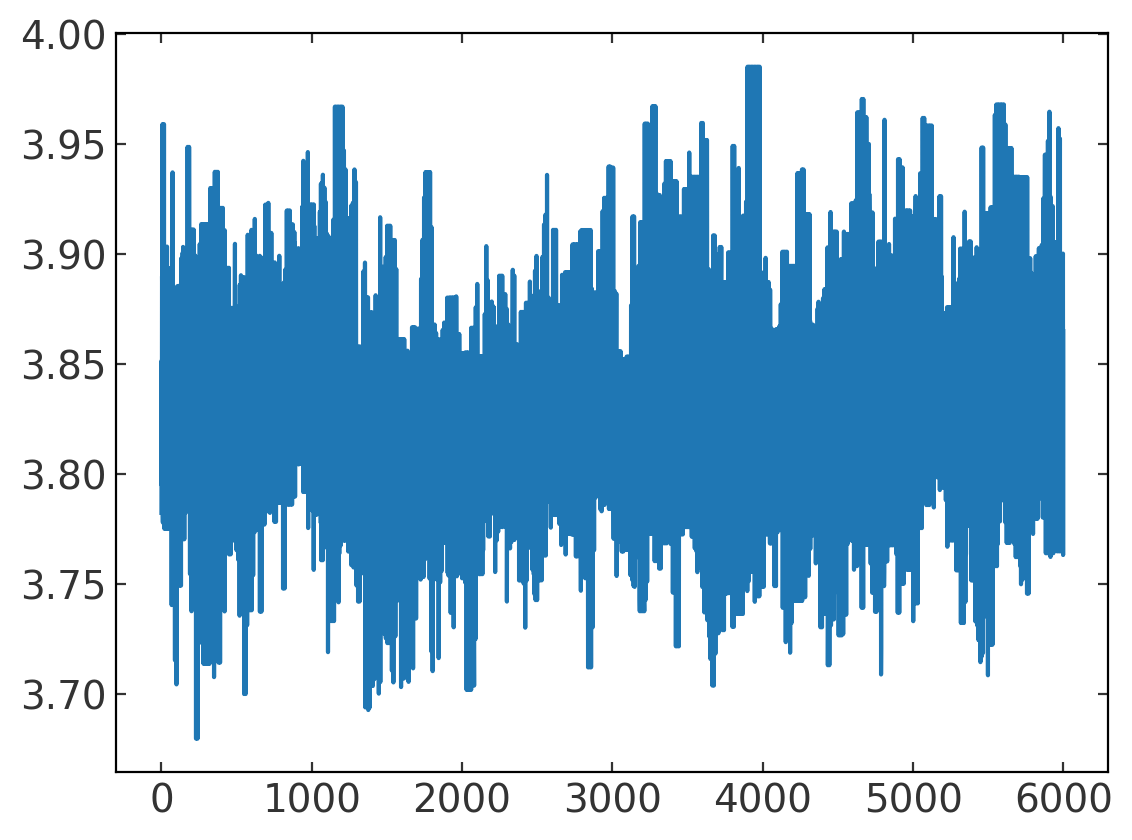

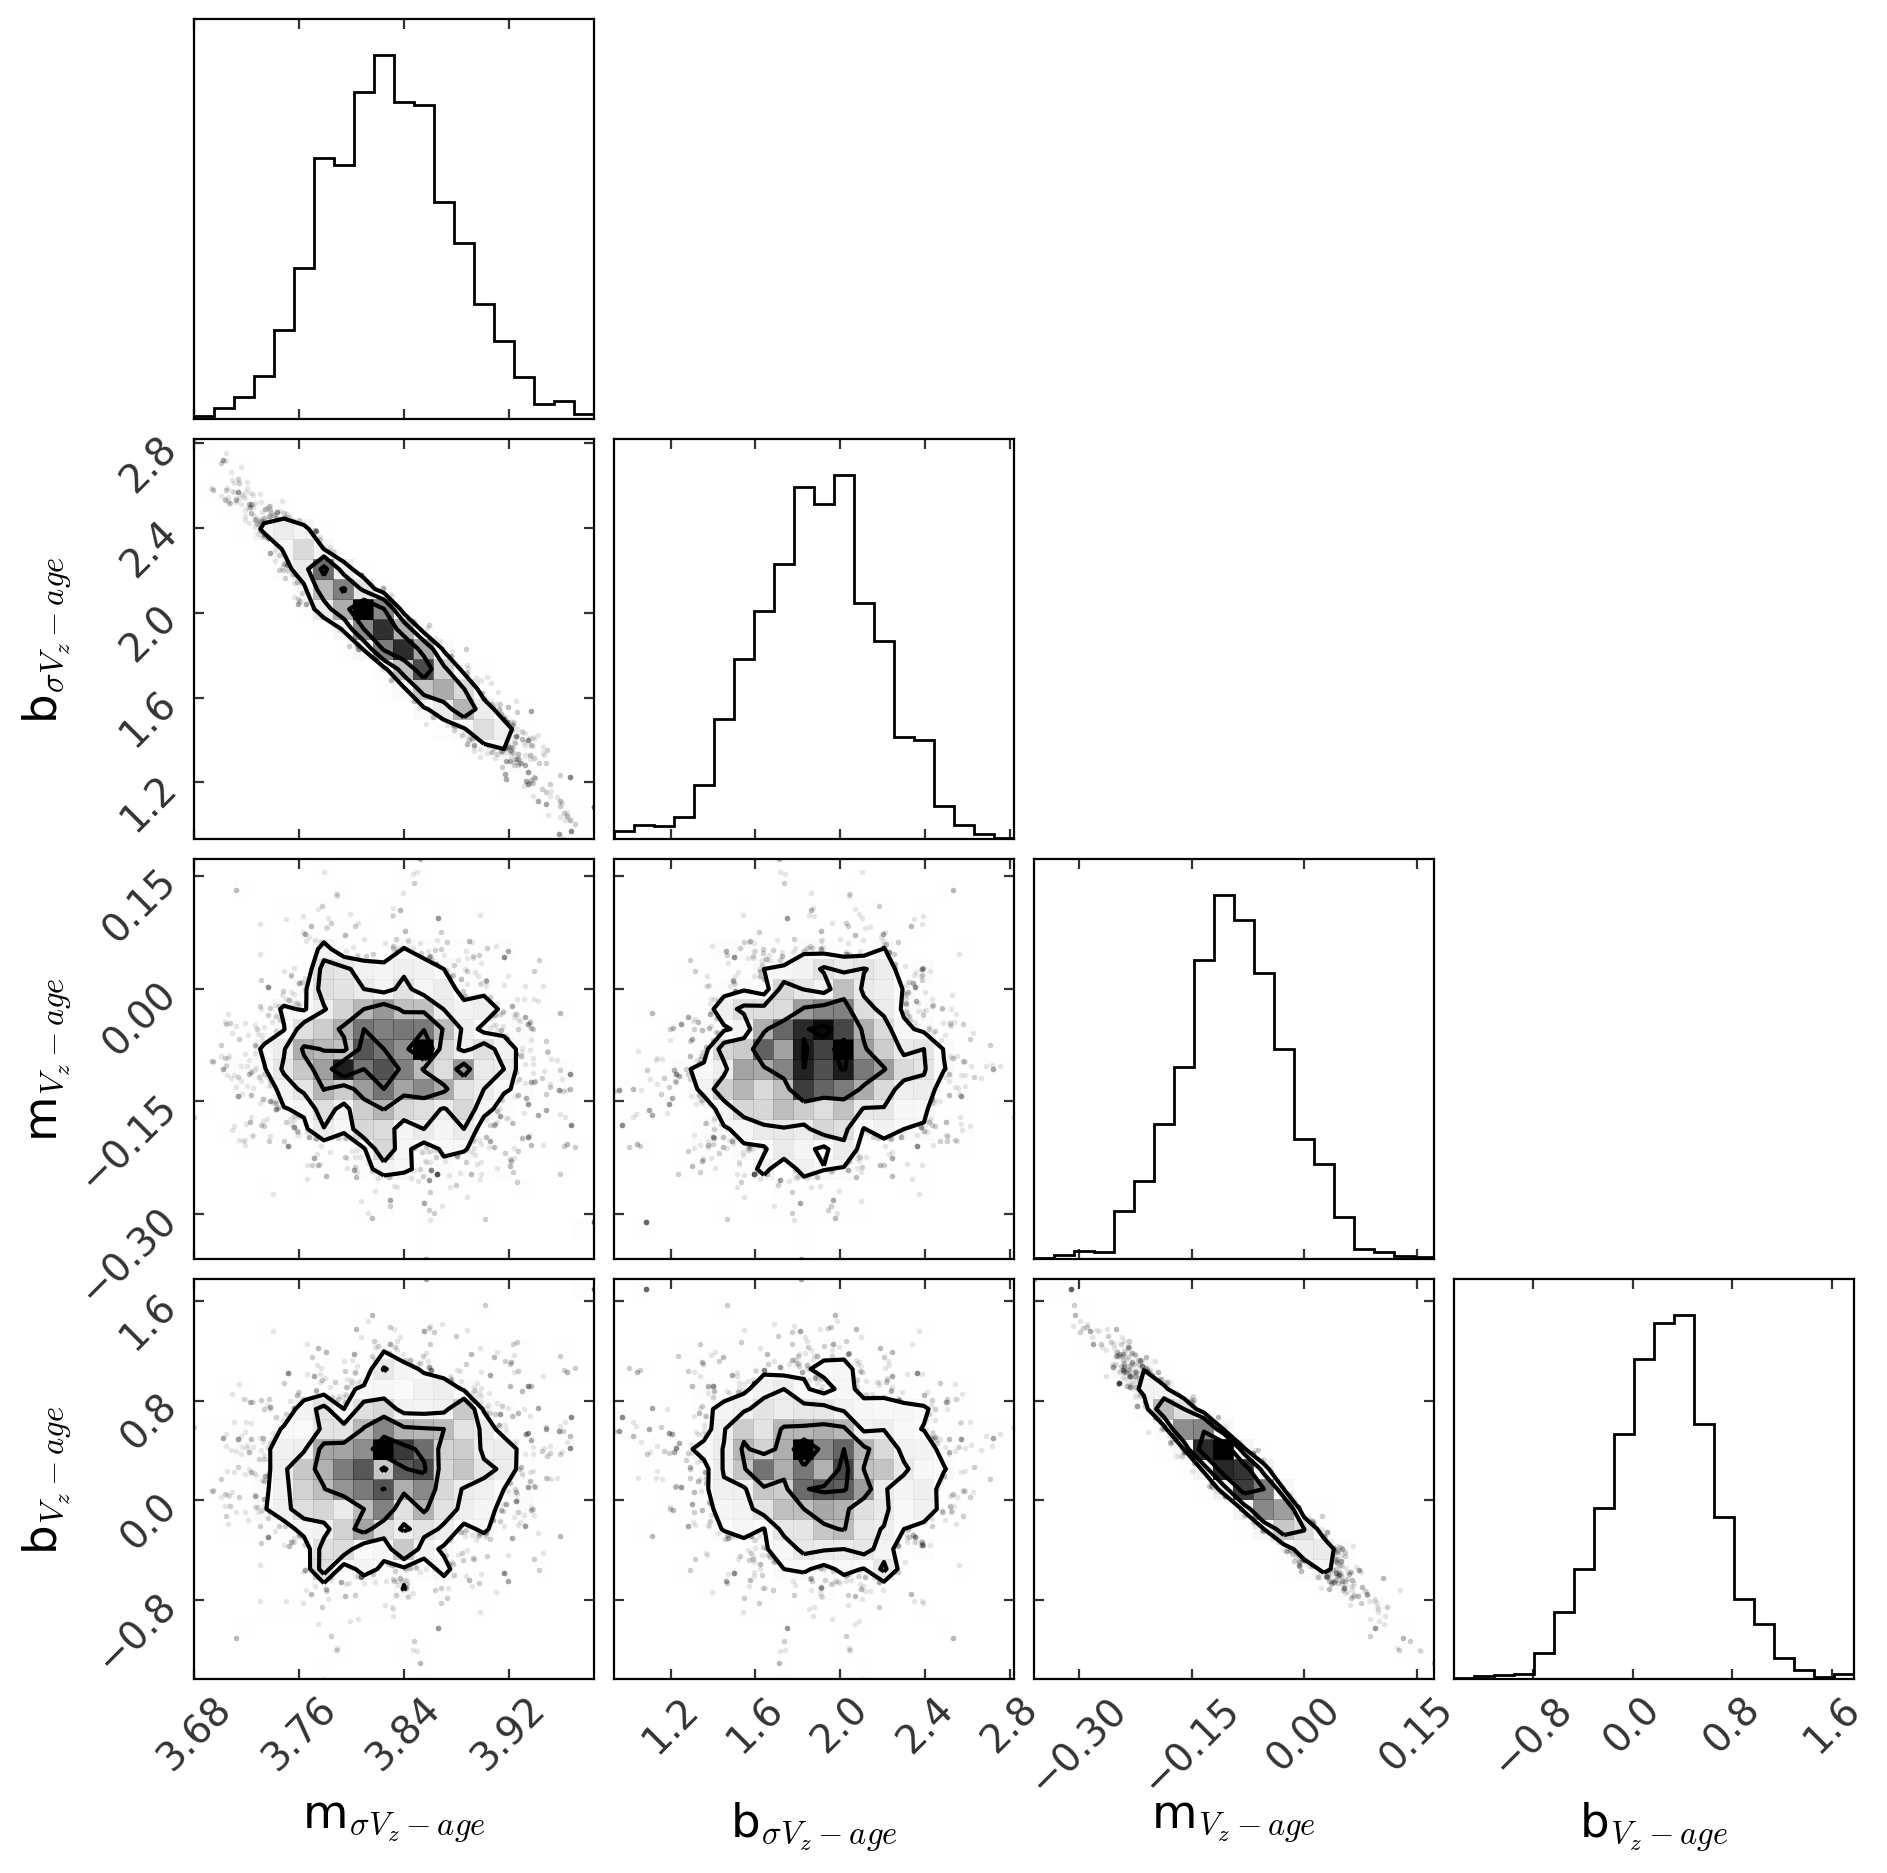

In [19]:
#--lets flatten the samples and make the corner plot to see our results.
flat_samples = sampler.get_chain(discard=400, flat=True)
p.plot(flat_samples[:,0])
labels = [r'm$_{\sigma V_z-age}$',r'b$_{\sigma V_z-age}$','m$_{V_z-age}$','b$_{V_z-age}$']
fig = corner.corner(flat_samples, labels=labels,)

In [20]:
print('Now we see that the slope of the age-velocity dispersion relation is %.2f +/- \
%.2f km/s per Gyr FOR APOGEE'%(np.median(flat_samples[:,0]),np.std(flat_samples[:,0])))


print('Finally, we find that the slope of the age-velocity relation is %.2f +/- \
%.2f km/s per Gyr FOR APOGEE'%(np.median(flat_samples[:,2]),np.std(flat_samples[:,2])))



Now we see that the slope of the age-velocity dispersion relation is 3.83 +/- 0.05 km/s per Gyr FOR APOGEE
Finally, we find that the slope of the age-velocity relation is -0.09 +/- 0.07 km/s per Gyr FOR APOGEE


## Reach Challenge II: If we want to measure the age of an unknown population of stars, is it better to use the Age-velocity dispersion (in Z) relation or the Age-velocity relation (in theta)?

In [21]:
initial = np.array([3,8,-6,250 ]) #lets start with some random starting points
nwalkers=10 #10 walkers to randomly explore the space via MCMC

ndim = len(initial)
p0 = [np.array(initial) +  0.5* np.random.randn(ndim)
      for i in range(nwalkers)] #initalize the walkers
data = (np.array(D_DR3["age"]), np.array(D_DR3["galvt_dr3"]),np.array(D_DR3["galvt_err_dr3"])) #lets add the data


sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob1, args=data) #set up the sampler

print("Running burn-in...") #lets burn in first
p0, _, _ = sampler.run_mcmc(p0, 1000)
sampler.reset()

print("Running production...") #lets do our last run.
sampler.run_mcmc(p0, 1000,progress=True)


Running burn-in...


  0%|          | 4/1000 [00:00<00:30, 32.58it/s]

Running production...


100%|██████████| 1000/1000 [00:35<00:00, 28.46it/s]


State([[  3.17277279   8.93162016  -6.80740249 251.53087922]
 [  3.25001783   8.46267193  -6.78415338 251.2750957 ]
 [  3.30298559   8.34930733  -6.83558445 251.74907954]
 [  3.15369687   9.11773598  -6.88114823 251.93484219]
 [  3.19264912   9.05490867  -6.88968922 251.94980714]
 [  3.23508212   8.54141207  -6.85359334 251.64158029]
 [  3.23236812   8.67627155  -6.73754323 250.91481085]
 [  3.23388703   8.59186088  -6.66578787 250.81128594]
 [  3.11817972   9.29792892  -6.80722734 251.34551921]
 [  3.18327058   9.0269609   -6.72844378 250.80873876]], log_prob=[-244519.32274987 -244519.78197599 -244520.2523514  -244519.21142348
 -244519.58512055 -244520.37934419 -244519.25773464 -244520.83407623
 -244520.55998795 -244520.1520949 ], blobs=None, random_state=('MT19937', array([1736973436, 4023452933, 3706901925, 3146092397, 1036323832,
       2435450498,  748461332,  698406045, 2578726619,  419057908,
       3751740831, 3946606388, 1768744499, 1253459815,  120050969,
        139888812, 1

Now we see that the slope of the age-velocity dispersion relation is 3.20 +/- 0.05 km/s per Gyr FOR APOGEE
Finally, we find that the slope of the age-velocity relation is -6.80 +/- 0.08 km/s per Gyr FOR APOGEE


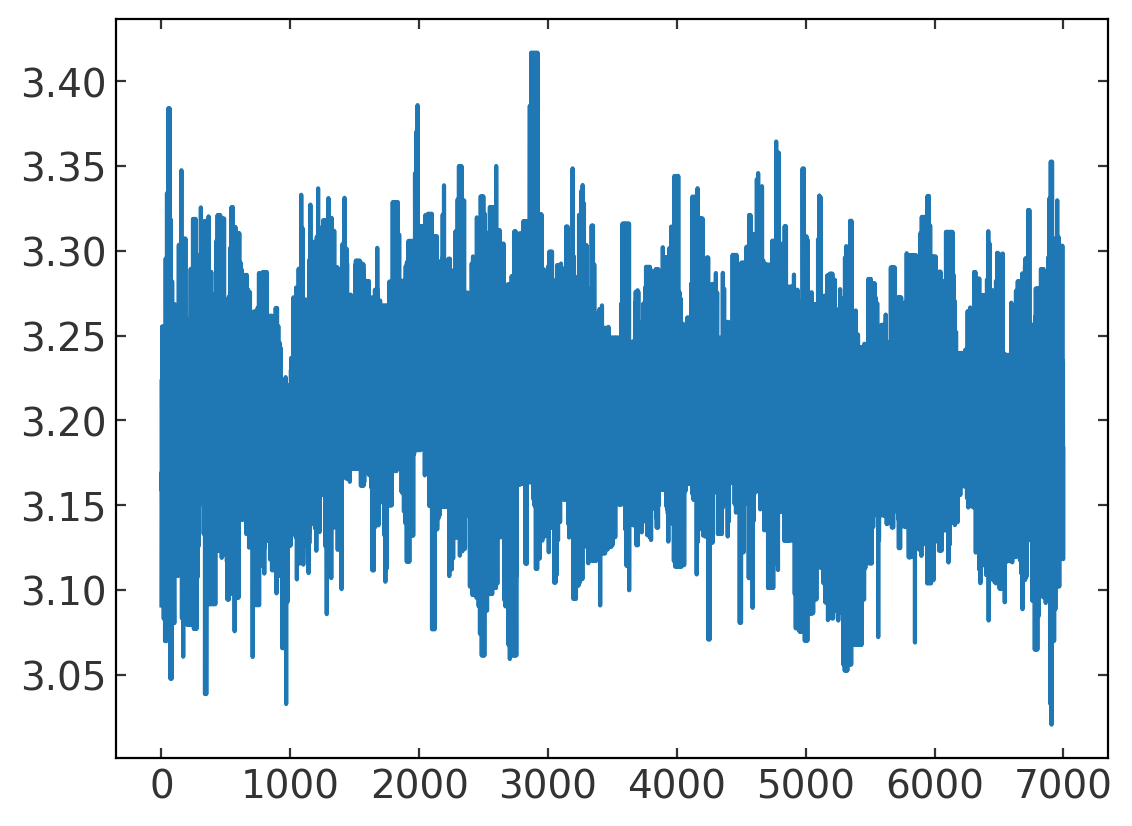

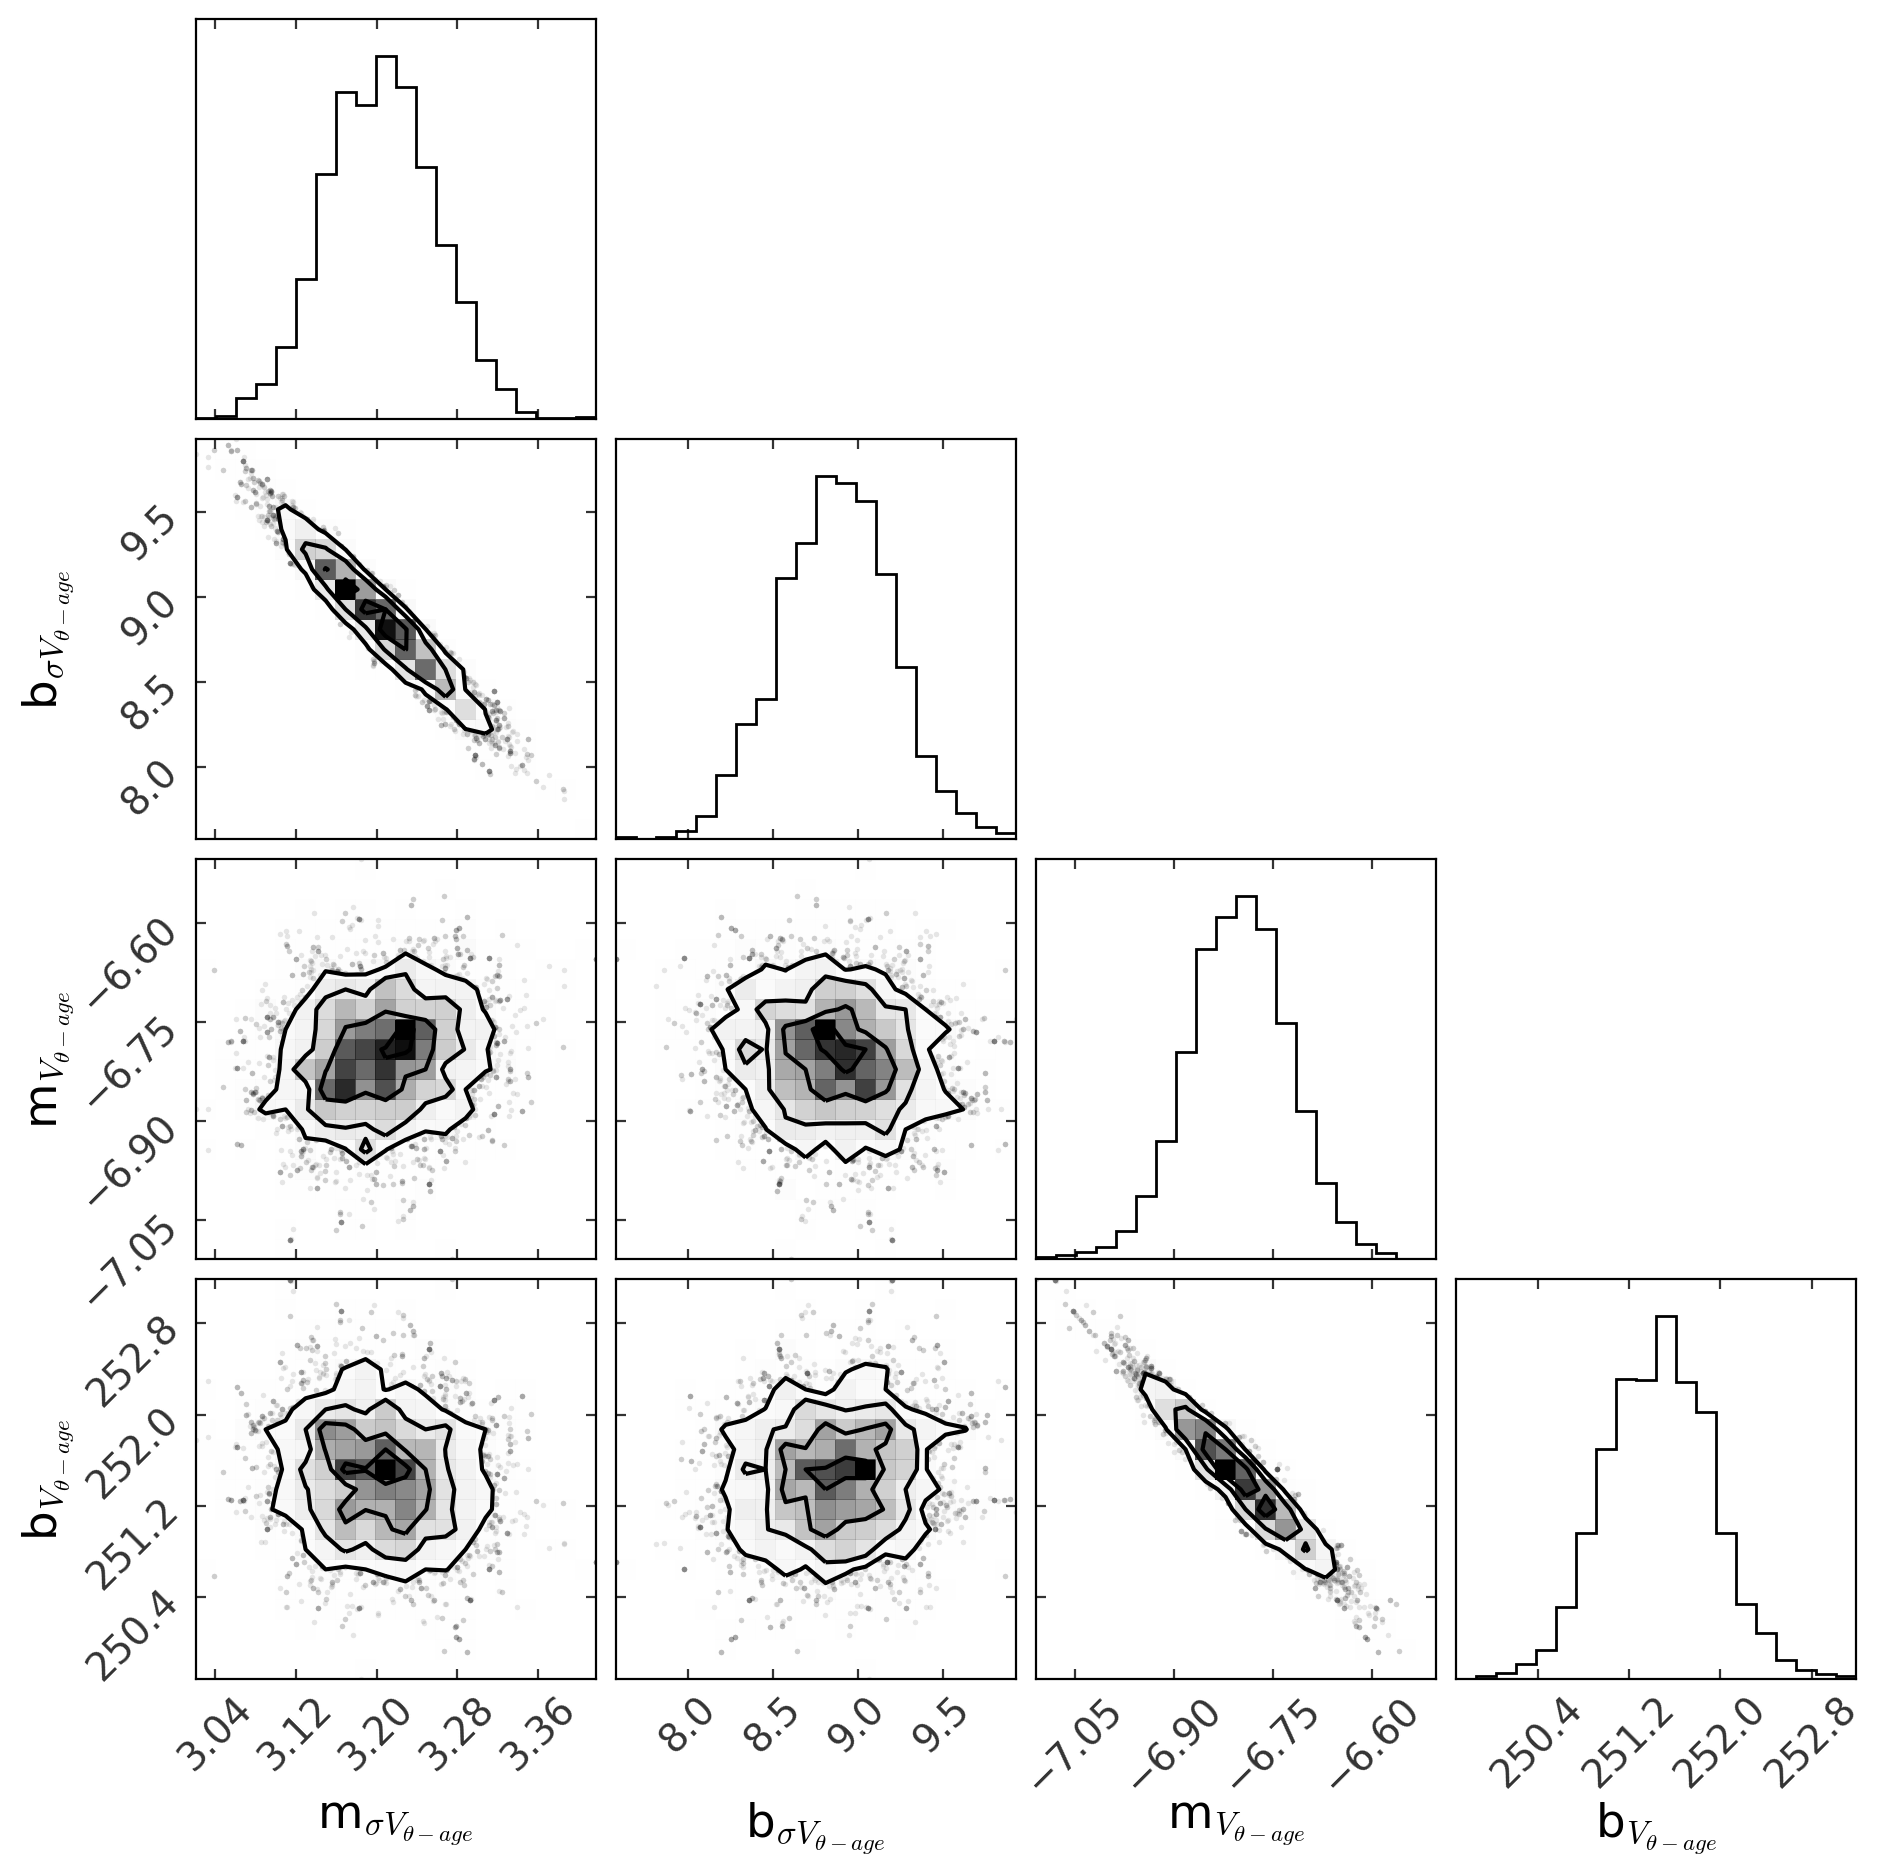

In [27]:
#--lets flatten the samples and make the corner plot to see our results.
flat_samples = sampler.get_chain(discard=300, flat=True)
p.plot(flat_samples[:,0])
labels = [r'm$_{\sigma V_{\theta-age}}$',r'b$_{\sigma V_{\theta-age}}$',r'm$_{V_{\theta -age}}}$',r'b$_{V_{\theta -age}}$']
fig = corner.corner(flat_samples, labels=labels,)

print('Now we see that the slope of the age-velocity dispersion relation is %.2f +/- \
%.2f km/s per Gyr FOR APOGEE'%(np.median(flat_samples[:,0]),np.std(flat_samples[:,0])))


print('Finally, we find that the slope of the age-velocity relation is %.2f +/- \
%.2f km/s per Gyr FOR APOGEE'%(np.median(flat_samples[:,2]),np.std(flat_samples[:,2])))



*Finally*, we find that the **Age-V$_\theta$ relation is actually steeper (and thus better to use) compared to the Age-V$_z$ dispersion relation**